# Audio Deepfake Detection -- Final Report

This notebook consolidates all experimental results for the audio deepfake detection project. It covers training data exploration, feature selection, per-model grid search details with evaluations on three datasets (FoR test, In-the-Wild, ElevenLabs).

---
## 0. Setup and Imports

In [46]:
import os, sys, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)

PROJECT_ROOT = os.path.dirname(os.path.abspath(os.getcwd()))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from configs.config import (
    FEATURES_DIR, ITW_DATASET_PATH, ELEVEN_LABS_FEATURES_PATH, FINAL_MODELS_PATH, FOR_MODELS_PATH
)
from utils.utils import evaluate_model_on_parquet, plot_roc_curve

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

print(f"Project root: {PROJECT_ROOT}")
print(f"Features dir: {FEATURES_DIR}")
print(f"Final models: {FINAL_MODELS_PATH}")
print(f"FoR models: {FOR_MODELS_PATH}")

Project root: c:\Users\geon9\MSc\audio-deepfake-detection
Features dir: c:\Users\geon9\MSc\audio-deepfake-detection\FoR_dataset\features
Final models: c:\Users\geon9\MSc\audio-deepfake-detection\notebooks\experiments\final
FoR models: c:\Users\geon9\MSc\audio-deepfake-detection\notebooks\experiments\FoR


In [47]:
# ── Dataset paths ──
TRAIN_PATH = os.path.join(FEATURES_DIR, "training_features_mean_20_128_256_128.parquet")
FOR_TEST_PATH = os.path.join(FEATURES_DIR, "testing_features_mean_20_128_256_128.parquet")
ITW_PATH = os.path.join(ITW_DATASET_PATH, "normalized_features",
                        "itw_features_mean_20_128_256_128_trimmed_loudness_normalized.parquet")
ELEVEN_PATH = os.path.join(ELEVEN_LABS_FEATURES_PATH,
                           "eleven_labs_features_mean_20_128_256_128.parquet")

# No-mel variants (for XGB_NO_MEL)
FOR_TEST_NO_MEL = os.path.join(FEATURES_DIR, "testing_features_mean_20_128_256_128_no_mel.parquet")
ITW_NO_MEL = os.path.join(ITW_DATASET_PATH, "normalized_features",
                          "itw_features_mean_20_128_256_128_no_mel_trimmed_loudness_normalized.parquet")
ELEVEN_NO_MEL = os.path.join(ELEVEN_LABS_FEATURES_PATH,
                             "eleven_labs_features_mean_20_128_256_128_no_mel.parquet")

# Verify paths exist
for name, p in [("Train", TRAIN_PATH), ("FoR Test", FOR_TEST_PATH),
                ("ITW", ITW_PATH), ("ElevenLabs", ELEVEN_PATH)]:
    print(f"{name}: {'OK' if os.path.exists(p) else 'MISSING'} -- {p}")


Train: OK -- c:\Users\geon9\MSc\audio-deepfake-detection\FoR_dataset\features\training_features_mean_20_128_256_128.parquet
FoR Test: OK -- c:\Users\geon9\MSc\audio-deepfake-detection\FoR_dataset\features\testing_features_mean_20_128_256_128.parquet
ITW: OK -- c:\Users\geon9\MSc\audio-deepfake-detection\in-the-wild-audio-deepfake\normalized_features\itw_features_mean_20_128_256_128_trimmed_loudness_normalized.parquet
ElevenLabs: OK -- c:\Users\geon9\MSc\audio-deepfake-detection\elevenlabs-dataset\features\eleven_labs_features_mean_20_128_256_128.parquet


In [48]:
# ── Best Model registry ──

MODEL_REGISTRY = {
    "Logistic Regression": ("logistic_reg/exp_20260207_192945", False),
    "Linear SVM":          ("linear_svm/exp_20260207_193304", False),
    "RBF SVM":             ("rbf_svm/exp_20260207_200752", False),
    "Polynomial SVM":      ("poly_svm/exp_20260207_201742", False),
    "Sigmoid SVM":         ("sigmoid_svm/exp_20260207_204305", False),
    "Decision Tree":       ("Dtree/exp_20260207_210558", False),
    "Random Forest":       ("RF/exp_20260208_163746", False),
    "XGBoost":             ("XGB/exp_20260208_160623", False),
    "XGBoost (no mel)":    ("XGB_NO_MEL/exp_20260208_034900", True),
}

FOR_REGISTRY = {
    "Logistic Regression": ("logistic_reg/exp_20260211_013736", False),
    "Linear SVM":          ("linear_svm/exp_20260211_013738", False),
    "RBF SVM":             ("rbf_svm/exp_20260211_013927", False),
    "Polynomial SVM":      ("poly_svm/exp_20260211_013945", False),
    "Sigmoid SVM":         ("sigmoid_svm/exp_20260211_014108", False),
    "Decision Tree":       ("Dtree/exp_20260211_014117", False),
    "Random Forest":       ("RF/exp_20260211_014126", False),
    "XGBoost":             ("XGB/exp_20260211_014131", False),
    "XGBoost (no mel)":    ("XGB_NO_MEL/exp_20260211_014133", True),
}

# Grid search spaces used for each model
GRID_SEARCH_SPACES = {
    "Logistic Regression": {
        "C": "np.logspace(-3, 2, 10)  [0.001 ... 100]",
        "penalty": ["l1", "l2"],
        "solver": ["saga"],
    },
    "Linear SVM": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    },
    "RBF SVM": {
        "kernel": ["rbf"],
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", 0.01, 0.1],
    },
    "Polynomial SVM": {
        "kernel": ["poly"],
        "degree": [2, 3],
        "C": [0.1, 1, 10],
        "gamma": ["scale", 0.01],
        "coef0": [0.0, 1.0],
    },
    "Sigmoid SVM": {
        "kernel": ["sigmoid"],
        "C": [0.01, 0.1, 1],
        "gamma": ["scale", 0.01],
        "coef0": [-1.0, 0.0, 1.0],
    },
    "Decision Tree": {
        "max_depth": "range(5, 20)",
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "class_weight": ["{0:1, 1:5}", None],
        "criterion": ["gini", "entropy"],
        "ccp_alpha": [0.0, 1e-4, 1e-3, 1e-2],
    },
    "Random Forest": {
        "n_estimators": [300, 500, 700, 800],
        "max_depth": [2, 3, 4, 5],
        "max_features": ["sqrt", "log2"],
        "min_samples_split": [5, 10, 20],
        "min_samples_leaf": [2, 5, 10],
        "max_samples": [0.5, 0.6, 0.7],
        "class_weight": ["{0:1, 1:5}", None],
    },
    "XGBoost": {
        "max_depth": [3, 4, 2],
        "learning_rate": [0.03, 0.05],
        "n_estimators": [700, 800],
        "min_child_weight": [10, 20],
        "gamma": [0.3],
        "reg_lambda": [2, 1],
        "reg_alpha": [0.5],
        "subsample": [0.6, 0.7, 0.5],
        "colsample_bytree": [0.6, 0.7],
        "scale_pos_weight": [2],
    },
    "XGBoost (no mel)": {
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.03, 0.05],
        "n_estimators": [300, 500, 700],
        "min_child_weight": [5, 10, 20],
        "gamma": [0.1, 0.3, 0.5],
        "reg_lambda": [2, 5, 10],
        "reg_alpha": [0, 0.5, 1],
        "subsample": [0.6, 0.7, 0.8],
        "colsample_bytree": [0.6, 0.7, 0.8],
        "scale_pos_weight": [1, 2, 3],
    },
}

print(f"Models registered: {len(MODEL_REGISTRY) + len(FOR_REGISTRY)}")


Models registered: 18


In [49]:
# ── Plot helpers (report-specific layout) ──


def plot_confusion_matrices(models, datasets, titles, suptitle=""):
    """Plot side-by-side confusion matrices. models[i] evaluates datasets[i]."""
    n = len(datasets)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))
    if n == 1:
        axes = [axes]
    for ax, mdl, (X, y), title in zip(axes, models, datasets, titles):
        y_pred = mdl.predict(X)
        cm = confusion_matrix(y, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
        disp.plot(ax=ax, colorbar=False)
        ax.set_title(title)
    if suptitle:
        fig.suptitle(suptitle, fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()


def plot_roc_curves_overlay(models, datasets, labels, title="ROC Curves"):
    """Plot ROC curves – one model per dataset, overlaid on one axes."""
    fig, ax = plt.subplots(figsize=(6, 5))
    for mdl, (X, y), label in zip(models, datasets, labels):
        plot_roc_curve(mdl, X, y, label=label, ax=ax)
    ax.set_title(title)
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


print("Helpers loaded.")



Helpers loaded.


---
## 1. Training Data Visualization

We inspect the FoR training feature set to understand class distributions and feature correlations.

In [50]:
# Load training data
train_df = pd.read_parquet(TRAIN_PATH)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

# Encode labels
train_df["label_num"] = train_df["label"].map({"real": 0, "fake": 1})

feature_cols = [c for c in train_df.columns if c not in ["label", "filename", "label_num"]]

print(f"Training samples: {len(train_df)}")
print(f"  Real: {(train_df['label_num'] == 0).sum()}")
print(f"  Fake: {(train_df['label_num'] == 1).sum()}")
print(f"Features: {len(feature_cols)}")

Training samples: 53864
  Real: 26938
  Fake: 26926
Features: 195


### 1.1 Feature Histograms (Real vs Fake)

For each feature group we plot the overlapping distributions of real and fake samples.

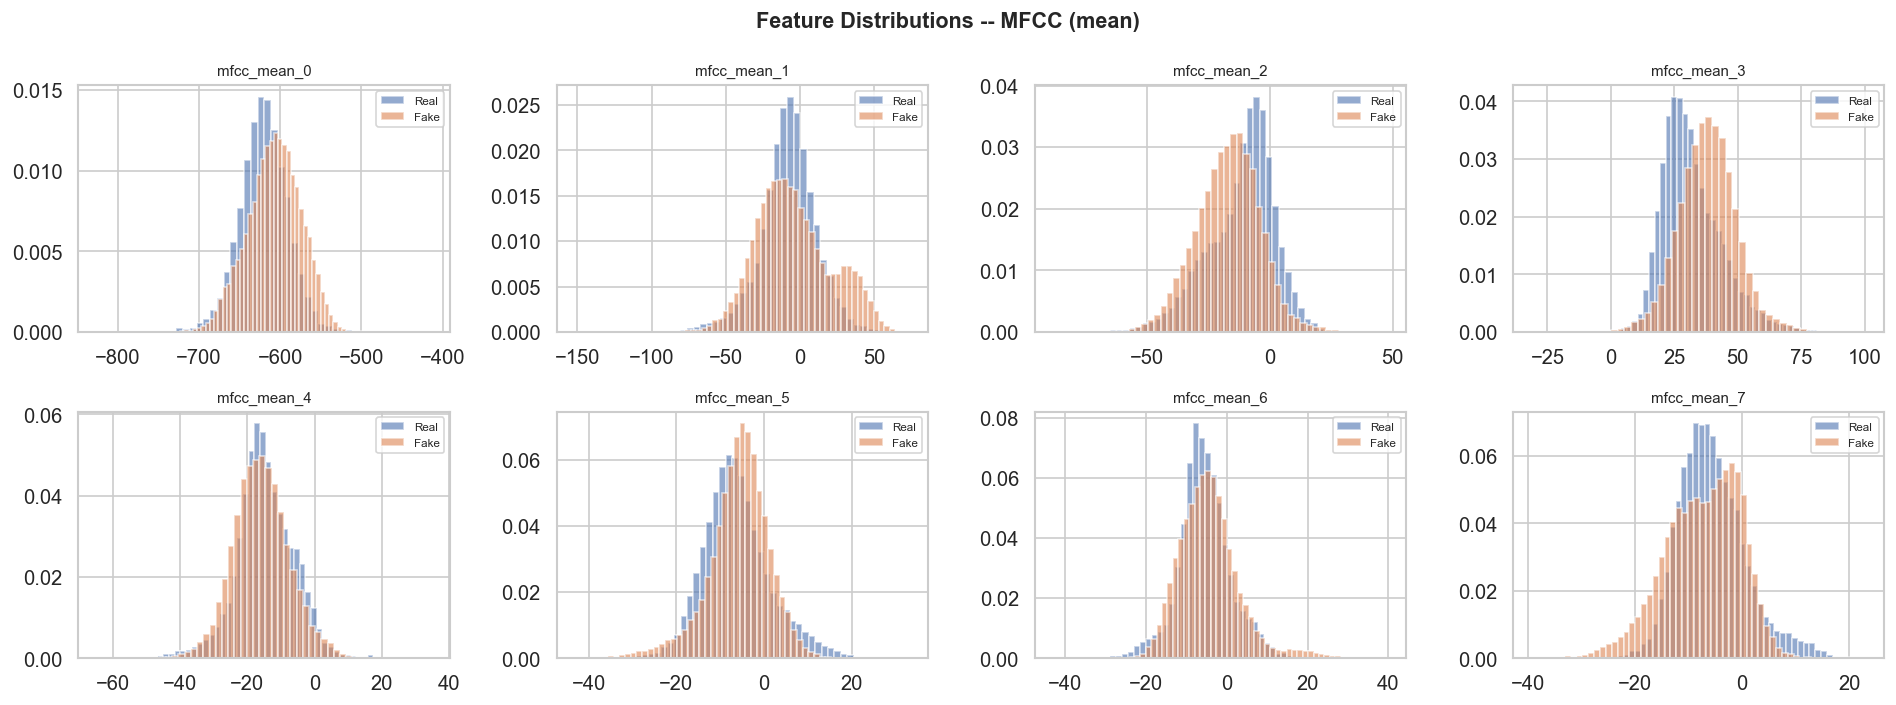

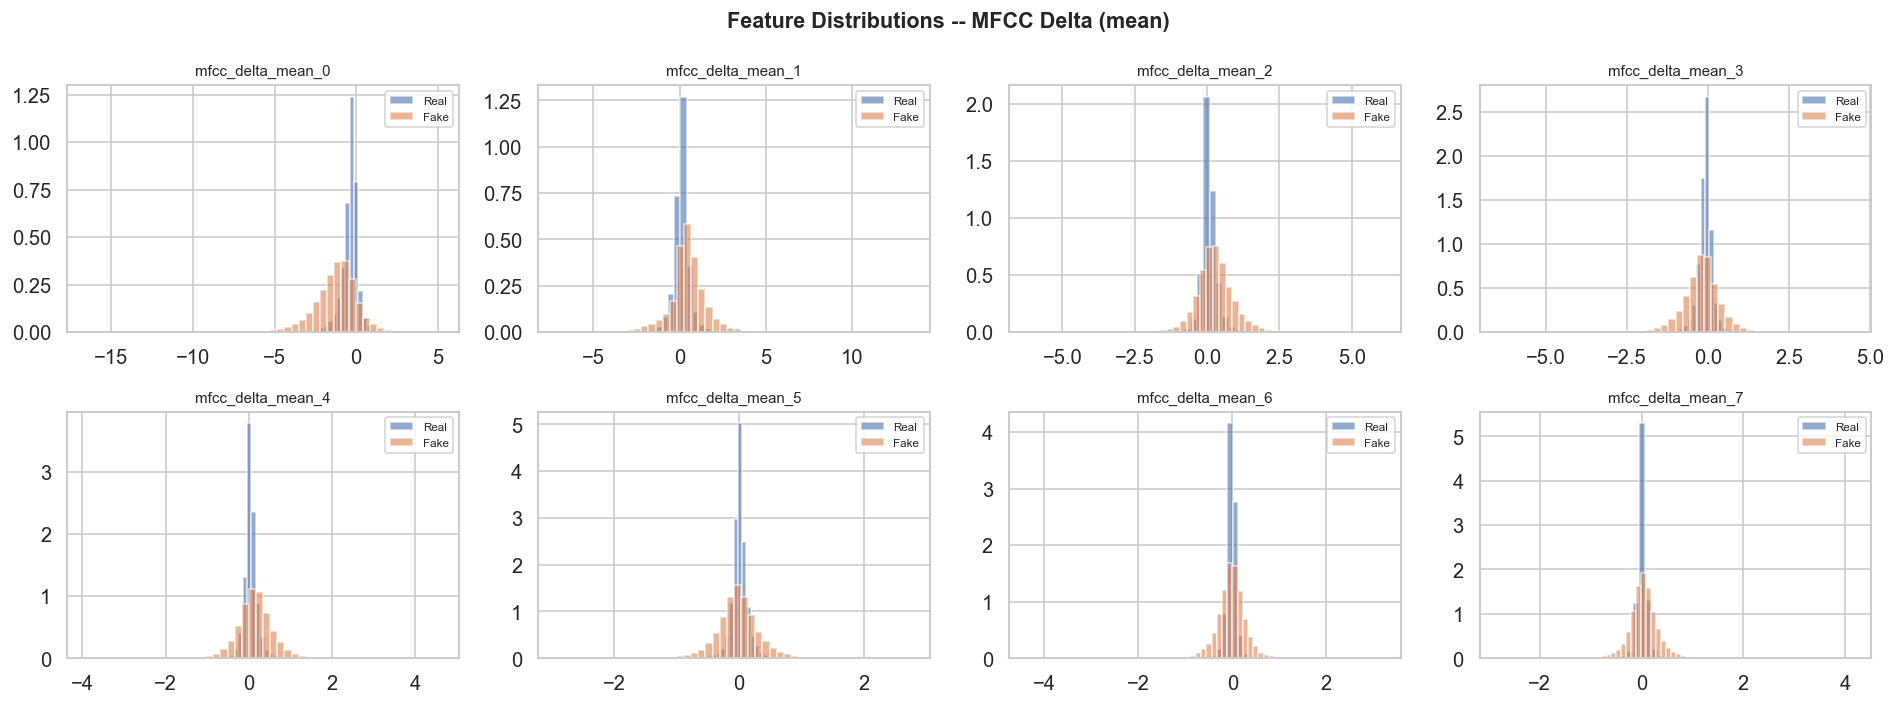

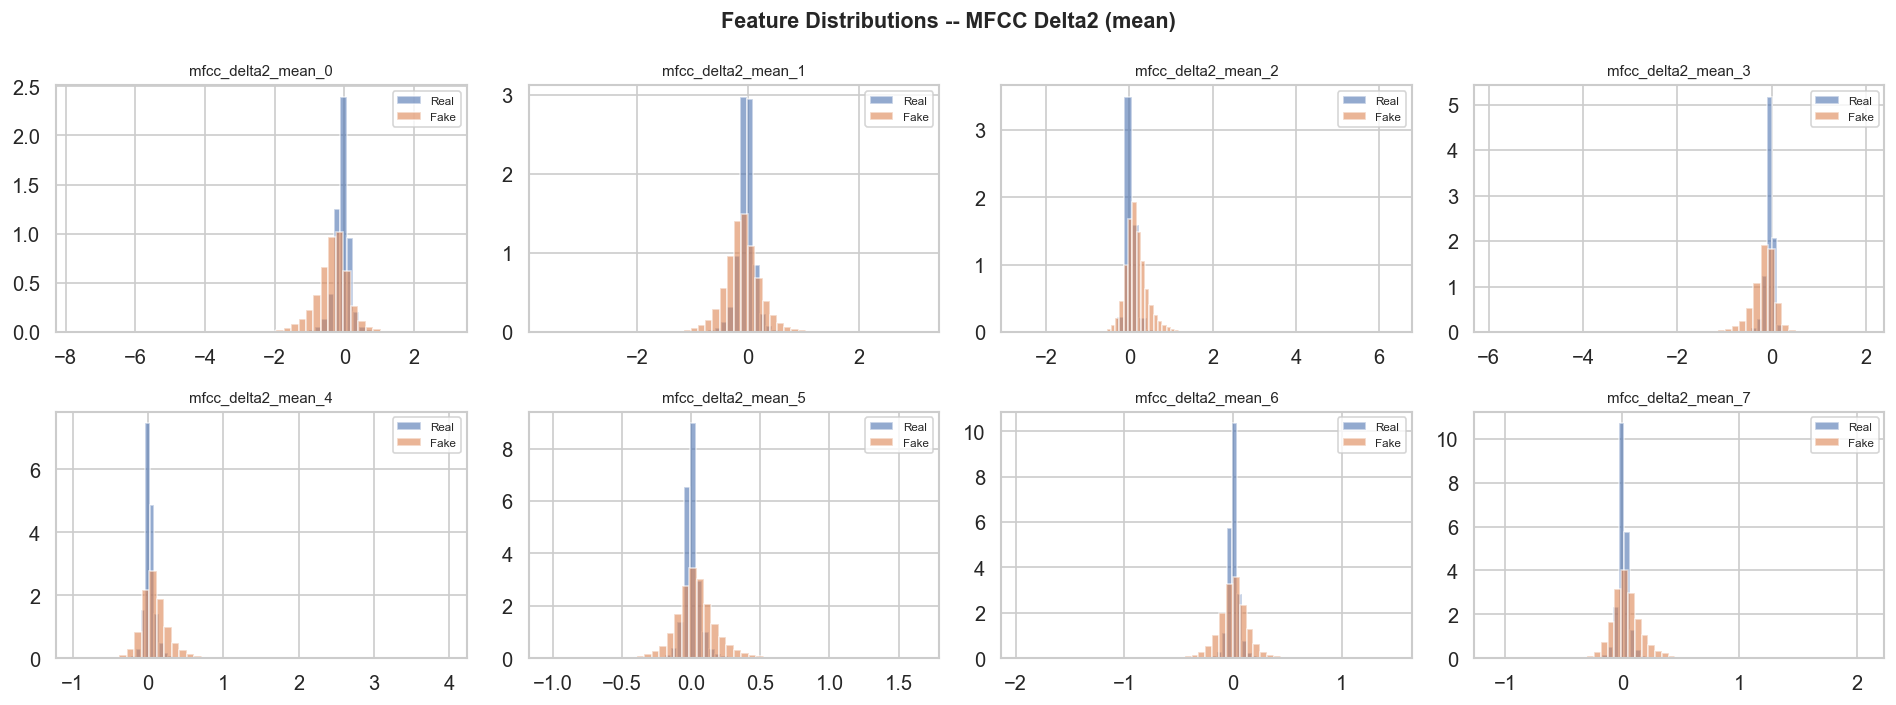

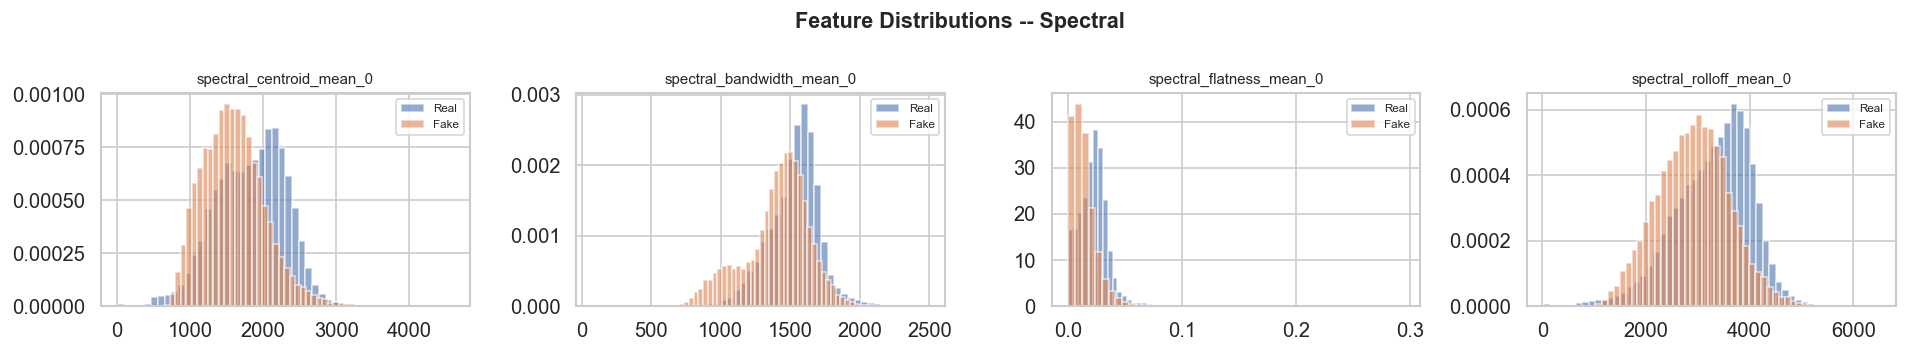

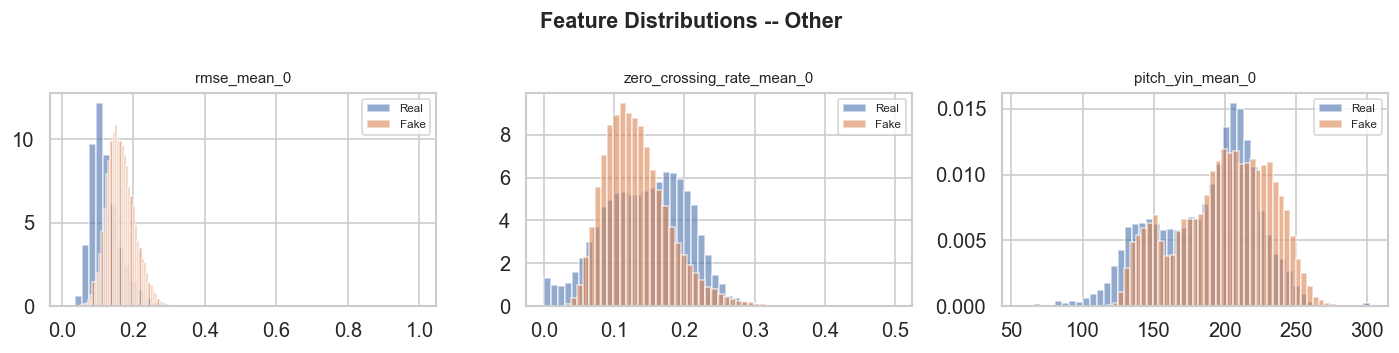

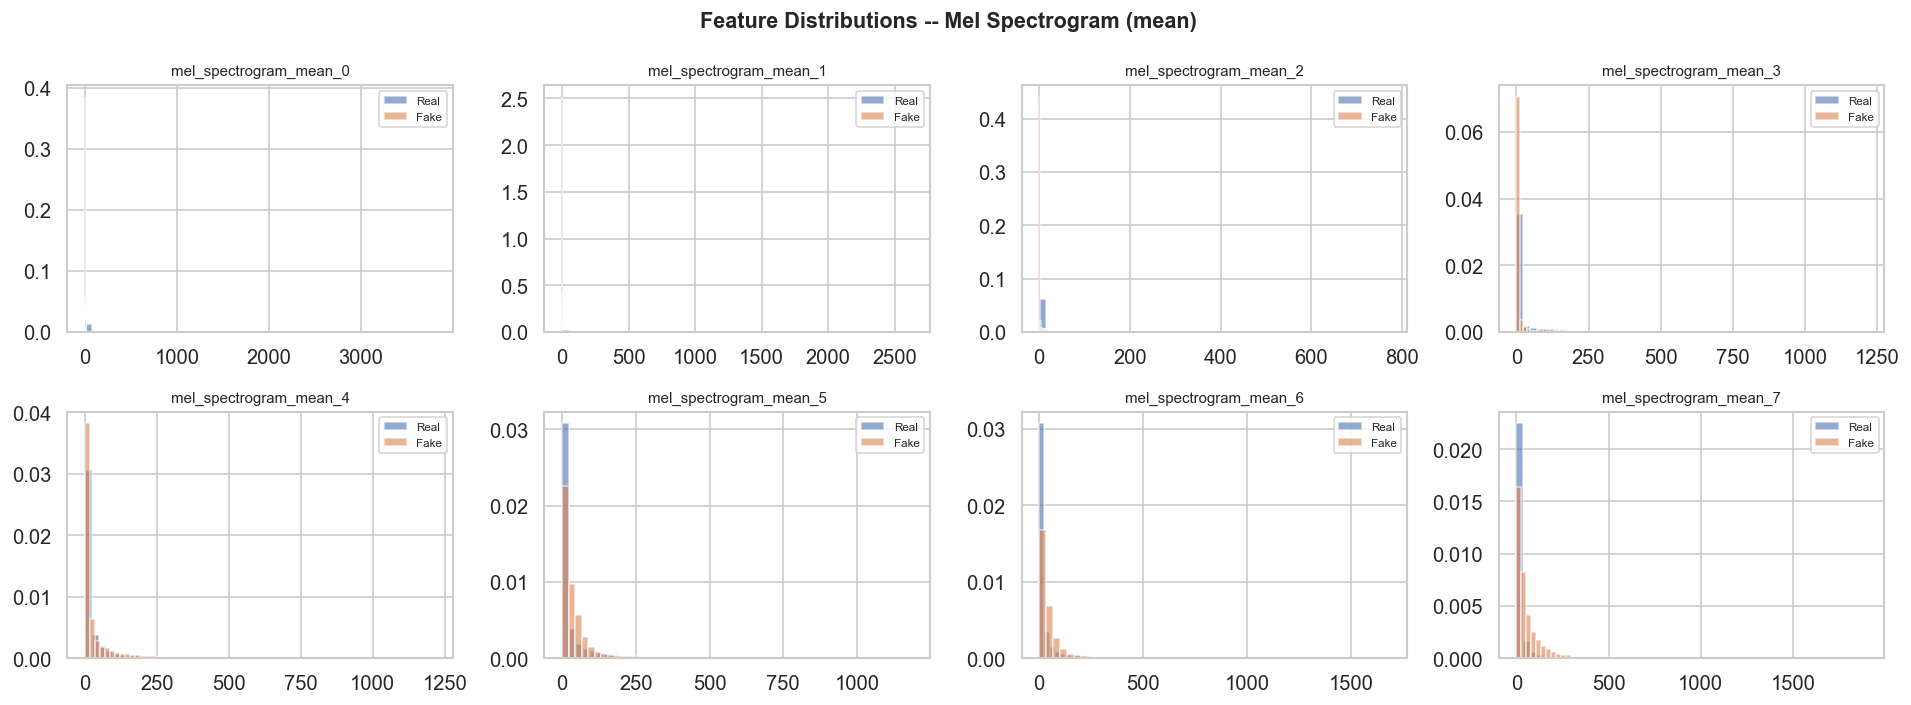

In [51]:
# Define feature groups with representative features
feature_groups = {
    "MFCC (mean)": [c for c in feature_cols if c.startswith("mfcc_mean_")],
    "MFCC Delta (mean)": [c for c in feature_cols if c.startswith("mfcc_delta_mean_")],
    "MFCC Delta2 (mean)": [c for c in feature_cols if c.startswith("mfcc_delta2_mean_")],
    "Spectral": [c for c in feature_cols if c.startswith("spectral_")],
    "Other": [c for c in feature_cols if c.startswith(("rmse_", "zero_crossing", "pitch_"))],
    "Mel Spectrogram (mean)": [c for c in feature_cols if c.startswith("mel_spectrogram_mean_")],
}

real_df = train_df[train_df["label_num"] == 0]
fake_df = train_df[train_df["label_num"] == 1]

for group_name, cols in feature_groups.items():
    # Show up to 8 representative features per group
    display_cols = cols[:8] if len(cols) > 8 else cols
    n = len(display_cols)
    ncols = min(4, n)
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
    axes = np.array(axes).flatten() if n > 1 else [axes]

    for i, col in enumerate(display_cols):
        axes[i].hist(real_df[col], bins=50, alpha=0.6, label="Real", density=True)
        axes[i].hist(fake_df[col], bins=50, alpha=0.6, label="Fake", density=True)
        axes[i].set_title(col, fontsize=9)
        axes[i].legend(fontsize=7)

    # Hide unused axes
    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(f"Feature Distributions -- {group_name}", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.show()

### 1.2 Correlation Heatmaps

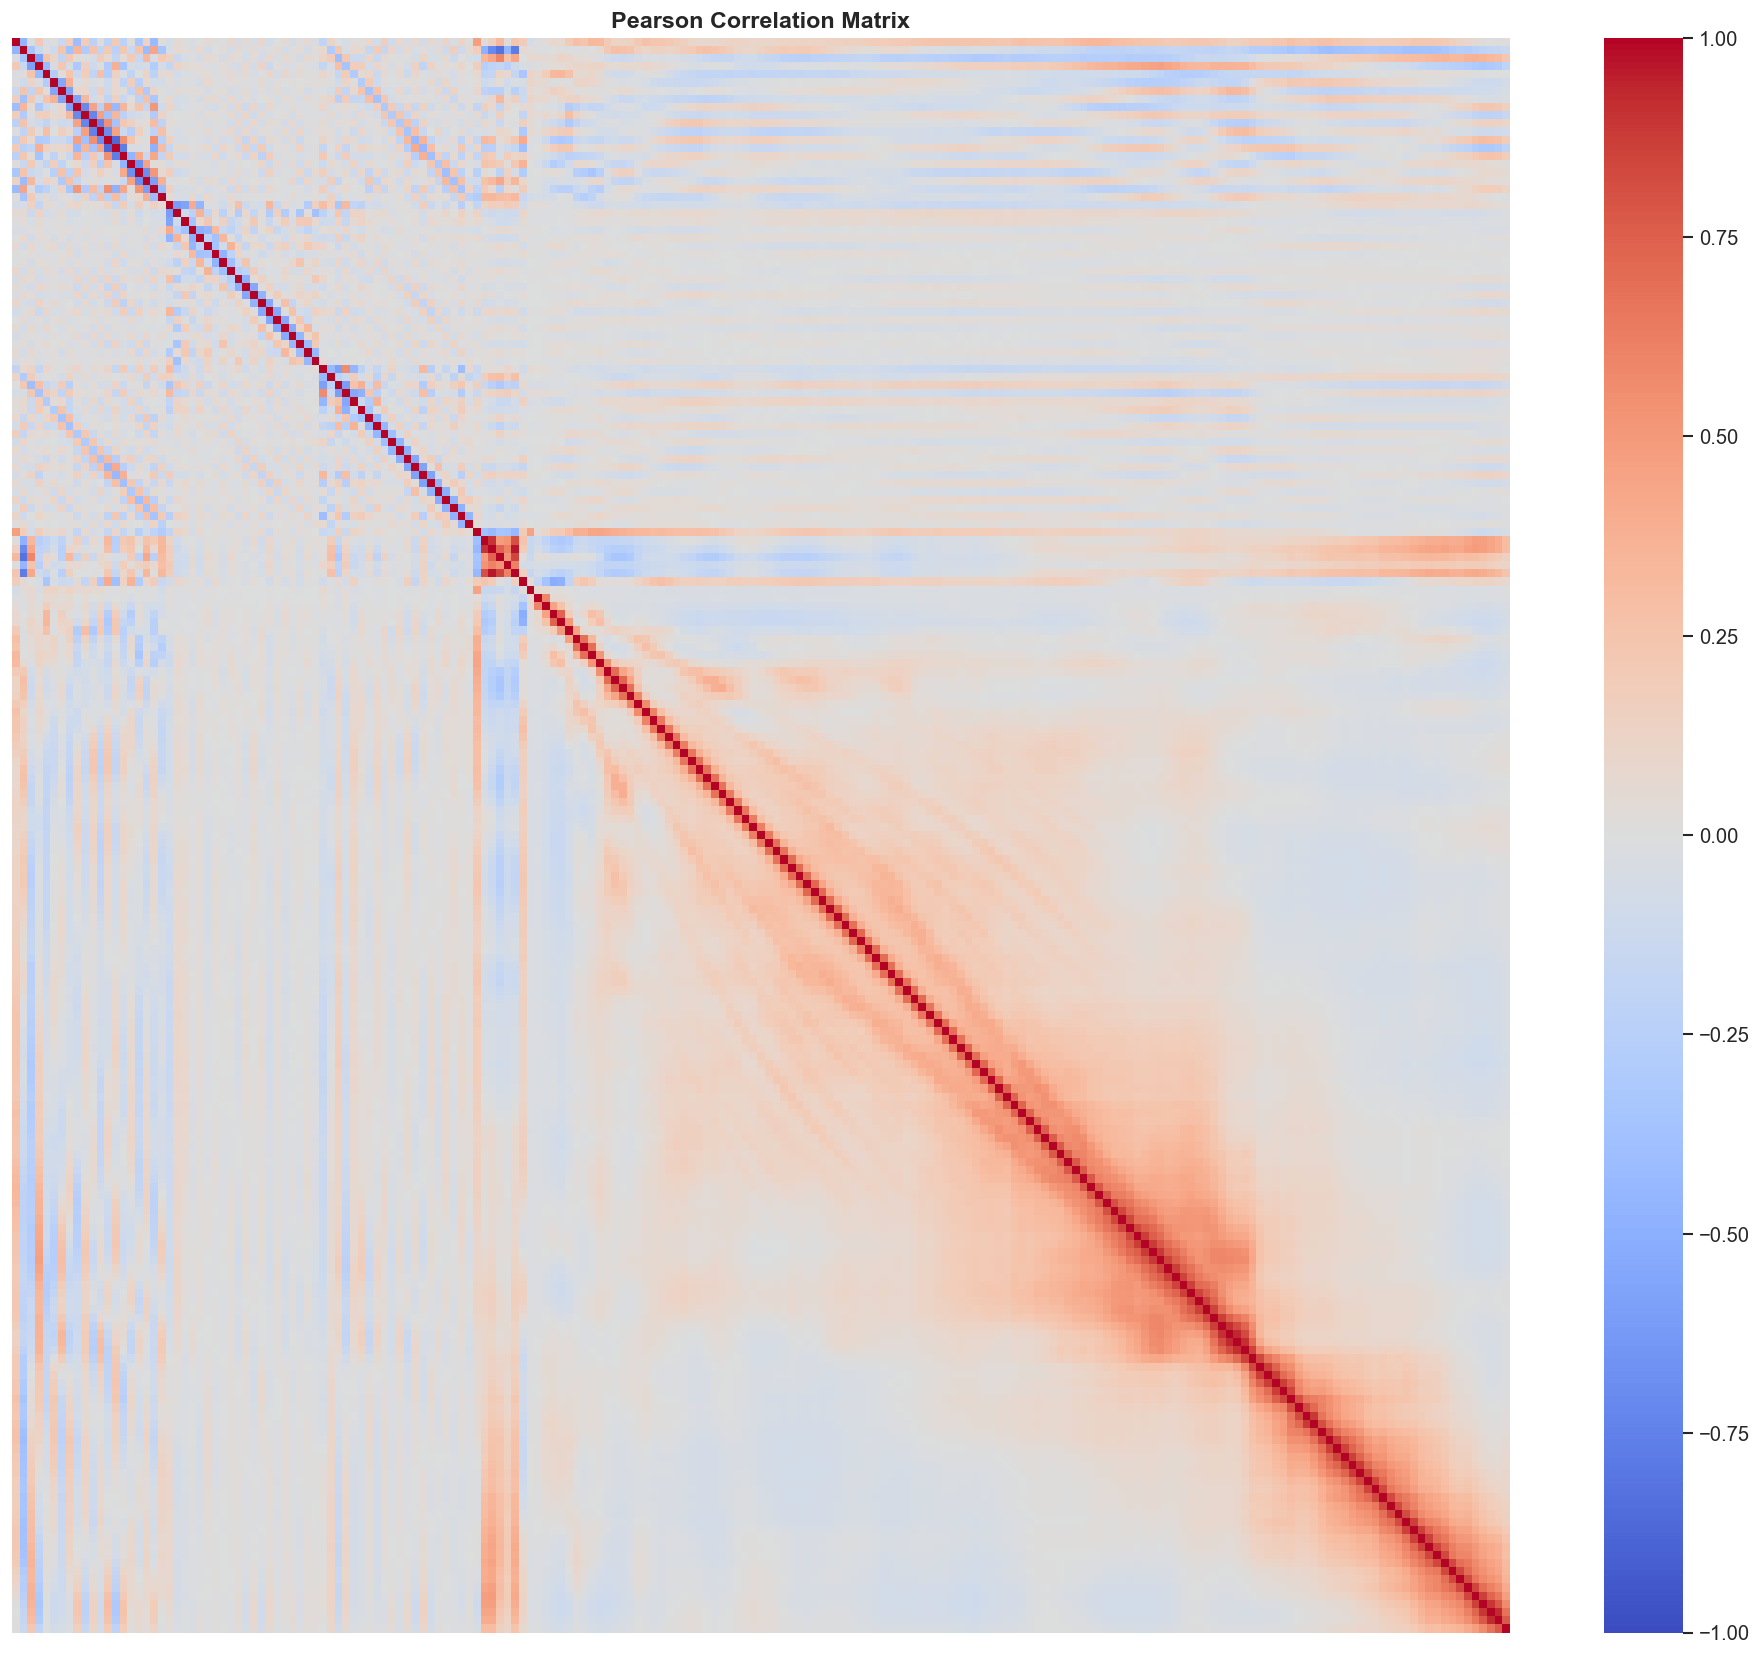

In [52]:
# Pearson correlation
corr_pearson = train_df[feature_cols].corr(method="pearson")

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr_pearson, cmap="coolwarm", center=0, vmin=-1, vmax=1,
            xticklabels=False, yticklabels=False, ax=ax)
ax.set_title("Pearson Correlation Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

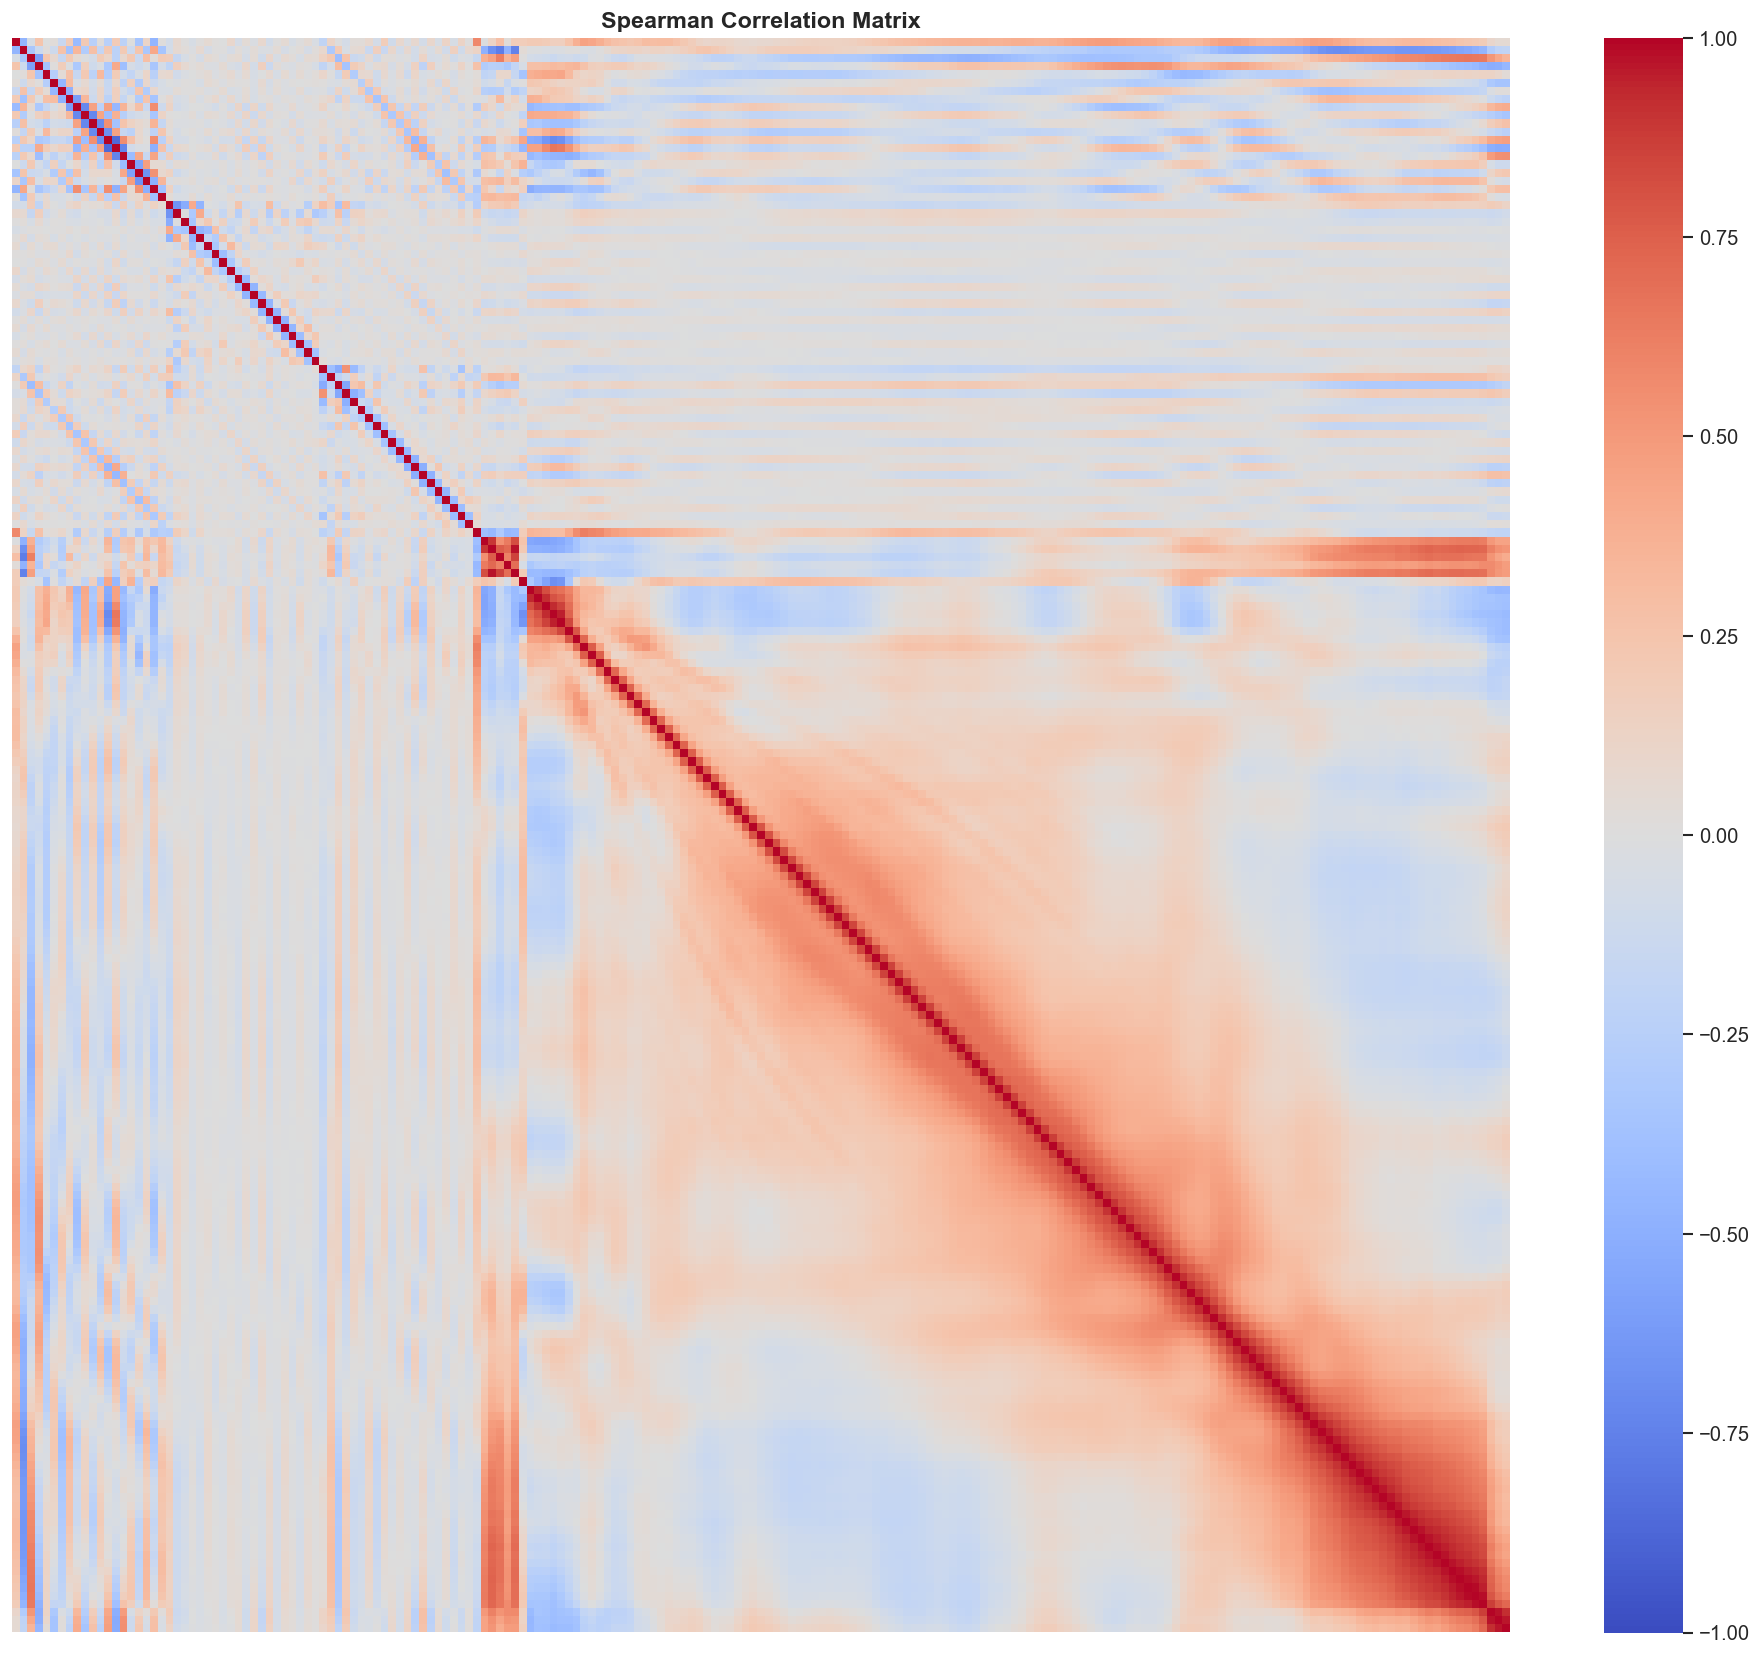

In [53]:
# Spearman correlation
corr_spearman = train_df[feature_cols].corr(method="spearman")

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr_spearman, cmap="coolwarm", center=0, vmin=-1, vmax=1,
            xticklabels=False, yticklabels=False, ax=ax)
ax.set_title("Spearman Correlation Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

---
## 2. Feature Selection

Our feature set was selected empirically by training a logistic regression model on different feature subsets and comparing prediction scores. We started with the full extracted feature set and progressively tested variants to identify which combination yielded the best performance.

The extracted audio features fall into the following groups:
- **MFCC** (20 coefficients) -- mean and standard deviation per coefficient
- **MFCC Delta** (20 coefficients) -- first-order temporal derivatives
- **MFCC Delta2** (20 coefficients) -- second-order temporal derivatives
- **Mel Spectrogram** (128 bands) -- mean and standard deviation per band
- **Spectral features** -- centroid, bandwidth, flatness, rolloff
- **Other** -- RMSE, zero-crossing rate, pitch (YIN)

Each feature was computed as both a **mean** and a **standard deviation** across all frames of the audio clip. For more information [`here`](./logistic_regression.ipynb) we are experimenting with feature selection.

In [54]:
# ── Feature subset comparison using Logistic Regression ──
# We trained the same Logistic Regression model on different feature subsets
# and compared prediction scores on the FoR validation set to decide which
# features to keep.

feature_variants = {
    "All features (mean + std)": {
        "Num. Features": "~394",
        "Description": "All extracted features including both mean and std aggregations",
        "Accuracy": 0.7225,
        "F1 (macro)": 0.7219,
        "ROC AUC": 0.7991,
    },
    "Without mel spectrogram": {
        "Num. Features": "~138",
        "Description": "Removed all 128 mel spectrogram bands (mean + std)",
        "Accuracy": 0.5490,
        "F1 (macro)": 0.5455,
        "ROC AUC": 0.5641,
    },
    "Mean only (selected)": {
        "Num. Features": "195",
        "Description": "Kept only mean aggregations, dropped all std features",
        "Accuracy": 0.7758,
        "F1 (macro)": 0.7751,
        "ROC AUC": 0.8543,
    },
}

variant_df = pd.DataFrame(feature_variants).T
variant_df.index.name = "Feature Set"

display(variant_df.style.format(
    {"Accuracy": "{:.4f}", "F1 (macro)": "{:.4f}", "ROC AUC": "{:.4f}"},
    subset=["Accuracy", "F1 (macro)", "ROC AUC"]
).background_gradient(
    cmap="RdYlGn", subset=["Accuracy", "F1 (macro)", "ROC AUC"], axis=0
))

,Num. Features,Description,Accuracy,F1 (macro),ROC AUC
Feature Set,,,,,
All features (mean + std),~394,All extracted features including both mean and std aggregations,0.7225,0.7219,0.7991
Without mel spectrogram,~138,Removed all 128 mel spectrogram bands (mean + std),0.5490,0.5455,0.5641
Mean only (selected),195,"Kept only mean aggregations, dropped all std features",0.7758,0.7751,0.8543


### How we chose the final feature set

We started with the full set of extracted audio features (~394 in total), which included both the **mean** and **standard deviation** of every feature computed across all frames of each audio clip.

We then trained a simple Logistic Regression classifier on three variants of the feature set and compared prediction scores:

1. **All features (mean + std, ~394)** -- Decent baseline (F1 = 0.72), but the standard-deviation features added noise rather than signal.
2. **Without mel spectrogram (~138)** -- Performance collapsed (F1 = 0.55), confirming that mel spectrogram bands carry critical information for distinguishing real from fake audio.
3. **Mean only, no std (195)** -- Best results (F1 = 0.78, ROC AUC = 0.85). Dropping the standard deviation aggregations removed noisy, redundant information and improved every metric.

Based on these results, we selected the **mean-only feature set (195 features)** for all subsequent model training. This set includes 20 MFCC means, 20 delta means, 20 delta2 means, 128 mel spectrogram band means, and 7 additional features (RMSE, ZCR, spectral centroid/bandwidth/flatness/rolloff, pitch).

---
## 3. Per-Model Results

For each of the 9 final models we show:
1. Grid search parameter space
2. Best hyperparameters selected
3. Metrics on FoR test set, In-the-Wild (ITW), and ElevenLabs
4. Confusion matrices on all three datasets
5. ROC AUC curves on all three datasets

In [55]:
# Pre-load test datasets for confusion matrices and ROC curves
from utils.utils import load_and_prepare_data

def _load_xy(path):
    """Load parquet and return (X, y) for plotting."""
    df = pd.read_parquet(path)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    X = df.drop(columns=["label", "filename"], errors="ignore")
    y = df["label"].map({"real": 0, "fake": 1}).values
    return X, y

print("Loading test datasets...")
X_for, y_for = _load_xy(FOR_TEST_PATH)
X_itw, y_itw = _load_xy(ITW_PATH)
X_eleven, y_eleven = _load_xy(ELEVEN_PATH)

# No-mel variants
X_for_nm, y_for_nm = _load_xy(FOR_TEST_NO_MEL) if os.path.exists(FOR_TEST_NO_MEL) else (None, None)
X_itw_nm, y_itw_nm = _load_xy(ITW_NO_MEL) if os.path.exists(ITW_NO_MEL) else (None, None)
X_eleven_nm, y_eleven_nm = _load_xy(ELEVEN_NO_MEL) if os.path.exists(ELEVEN_NO_MEL) else (None, None)

print(f"FoR test:    {X_for.shape}")
print(f"ITW:         {X_itw.shape}")
print(f"ElevenLabs:  {X_eleven.shape}")
if X_for_nm is not None: print(f"FoR (no mel): {X_for_nm.shape}")
if X_itw_nm is not None: print(f"ITW (no mel): {X_itw_nm.shape}")
if X_eleven_nm is not None: print(f"ElevenLabs (no mel): {X_eleven_nm.shape}")

Loading test datasets...
FoR test:    (4634, 195)
ITW:         (31526, 195)
ElevenLabs:  (136, 195)
FoR (no mel): (4634, 67)
ITW (no mel): (31526, 67)
ElevenLabs (no mel): (136, 67)


In [56]:
# ── Collect all results for later summary ──
all_results = {}  # model_name -> {"FoR": metrics, "ITW": metrics, "ElevenLabs": metrics}
all_predictions = {}  # for confusion matrices in Section 4

### 3.1 Logistic Regression

In [57]:
name = "Logistic Regression"

# Load FoR-trained model and final (grid-search best) model
for_dir = os.path.join(FOR_MODELS_PATH, FOR_REGISTRY[name][0])
for_model = joblib.load(os.path.join(for_dir, "model.joblib"))

final_dir = os.path.join(FINAL_MODELS_PATH, MODEL_REGISTRY[name][0])
final_model = joblib.load(os.path.join(final_dir, "model.joblib"))
with open(os.path.join(final_dir, "model_params.json")) as f:
    best_params = json.load(f)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")
print(f"\nBest Parameters: {json.dumps(best_params, indent=2)}")

# Evaluate: FoR model → FoR test,  Final model → ITW & ElevenLabs
m_for, _ = evaluate_model_on_parquet(for_model, FOR_TEST_PATH)
m_itw, _ = evaluate_model_on_parquet(final_model, ITW_PATH)
m_eleven, _ = evaluate_model_on_parquet(final_model, ELEVEN_PATH)

results = {"FoR Test": m_for, "ITW": m_itw, "ElevenLabs": m_eleven}
results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

# For confusion matrices & ROC curves
datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
models = [for_model, final_model, final_model]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

all_results[name] = results


Grid Search Space:
  C: np.logspace(-3, 2, 10)  [0.001 ... 100]
  penalty: ['l1', 'l2']
  solver: ['saga']

Best Parameters: {
  "clf__C": 2.1544346900318843,
  "clf__max_iter": 1000,
  "clf__penalty": "l2",
  "clf__solver": "saga"
}


,accuracy,precision,recall,f1_macro,roc_auc
FoR Test,0.7279,0.7875,0.7226,0.7099,0.9022
ITW,0.7163,0.7060,0.7179,0.7073,0.7775
ElevenLabs,0.6029,0.7070,0.5671,0.4988,0.6541


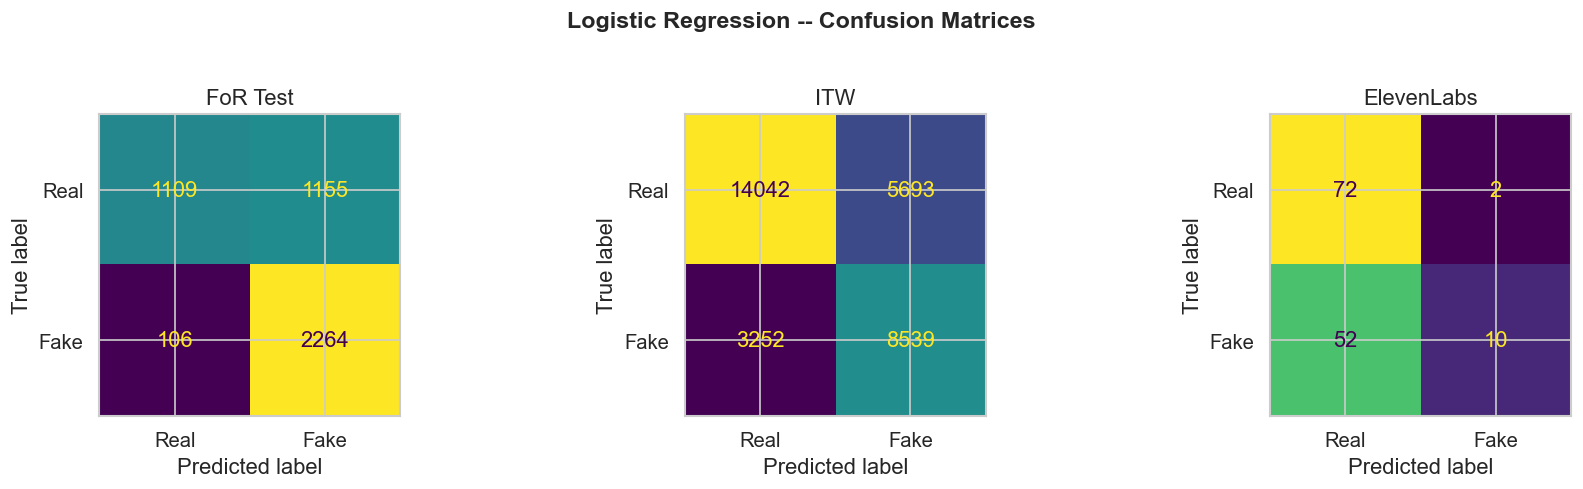

In [58]:
plot_confusion_matrices(models, datasets, ds_names, suptitle="Logistic Regression -- Confusion Matrices")


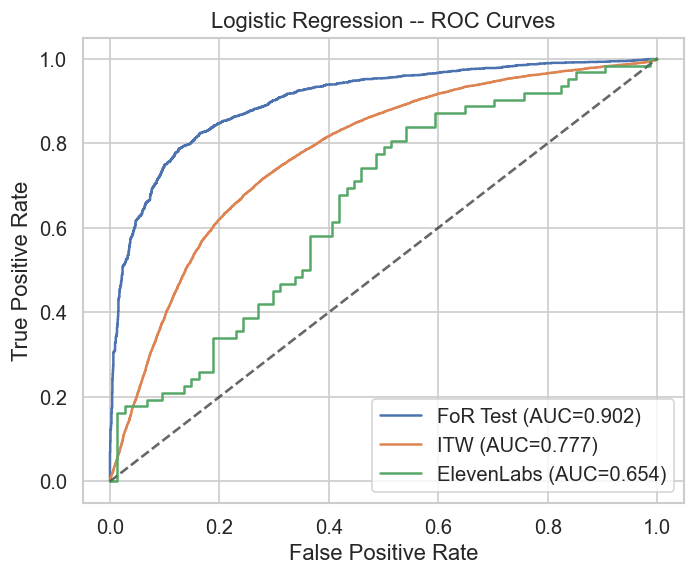

In [59]:
plot_roc_curves_overlay(models, datasets, ds_names, title="Logistic Regression -- ROC Curves")


### 3.2 Linear SVM

In [60]:
name = "Linear SVM"

# Load FoR-trained model and final (grid-search best) model
for_dir = os.path.join(FOR_MODELS_PATH, FOR_REGISTRY[name][0])
for_model = joblib.load(os.path.join(for_dir, "model.joblib"))

final_dir = os.path.join(FINAL_MODELS_PATH, MODEL_REGISTRY[name][0])
final_model = joblib.load(os.path.join(final_dir, "model.joblib"))
with open(os.path.join(final_dir, "model_params.json")) as f:
    best_params = json.load(f)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")
print(f"\nBest Parameters: {json.dumps(best_params, indent=2)}")

# Evaluate: FoR model → FoR test,  Final model → ITW & ElevenLabs
m_for, _ = evaluate_model_on_parquet(for_model, FOR_TEST_PATH)
m_itw, _ = evaluate_model_on_parquet(final_model, ITW_PATH)
m_eleven, _ = evaluate_model_on_parquet(final_model, ELEVEN_PATH)

results = {"FoR Test": m_for, "ITW": m_itw, "ElevenLabs": m_eleven}
results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

# For confusion matrices & ROC curves
datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
models = [for_model, final_model, final_model]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

all_results[name] = results


Grid Search Space:
  C: [0.001, 0.01, 0.1, 1, 10, 100, 1000]

Best Parameters: {
  "svm__C": 0.01
}


,accuracy,precision,recall,f1_macro,roc_auc
FoR Test,0.7052,0.7741,0.6993,0.6815,0.8904
ITW,0.7200,0.7075,0.7181,0.7097,0.7811
ElevenLabs,0.6103,0.7158,0.5752,0.5121,0.6707


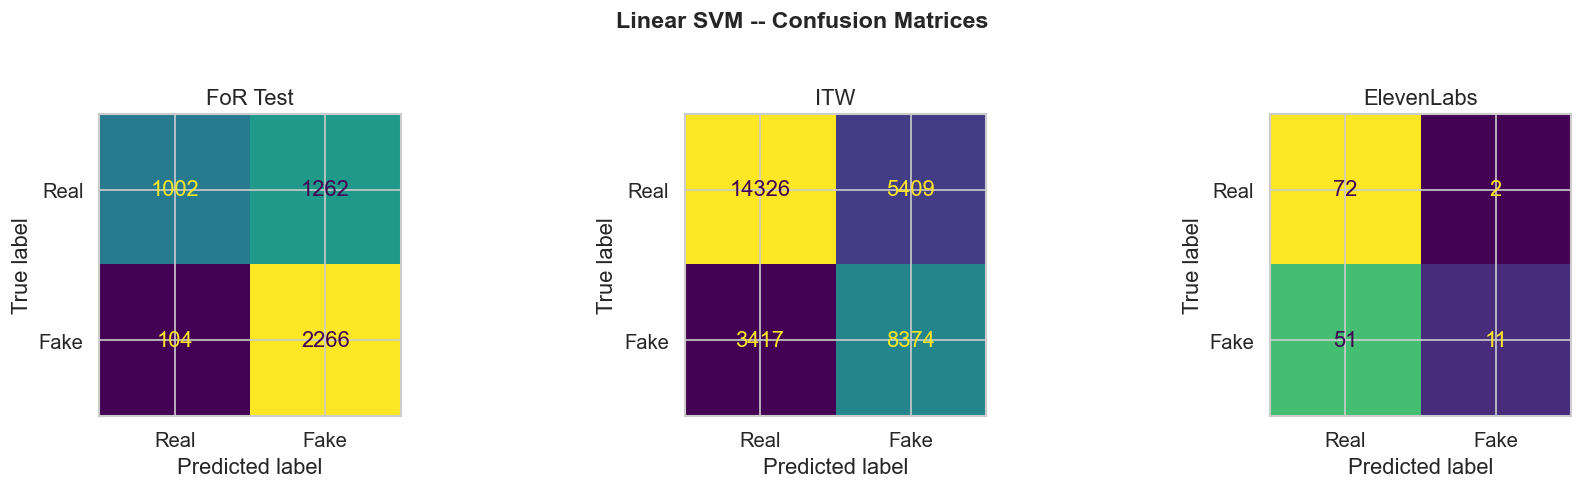

In [61]:
plot_confusion_matrices(models, datasets, ds_names, suptitle="Linear SVM -- Confusion Matrices")


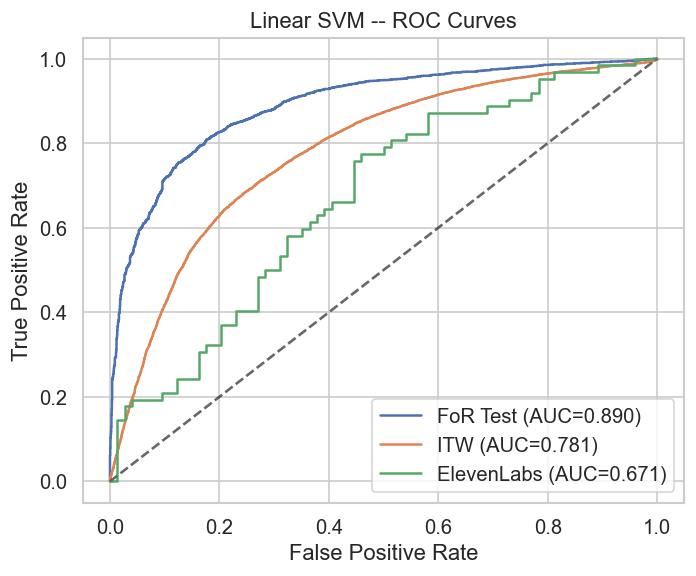

In [62]:
plot_roc_curves_overlay(models, datasets, ds_names, title="Linear SVM -- ROC Curves")


### 3.3 RBF SVM

In [ ]:
name = "RBF SVM"

# Load FoR-trained model and final (grid-search best) model
for_dir = os.path.join(FOR_MODELS_PATH, FOR_REGISTRY[name][0])
for_model = joblib.load(os.path.join(for_dir, "model.joblib"))

final_dir = os.path.join(FINAL_MODELS_PATH, MODEL_REGISTRY[name][0])
final_model = joblib.load(os.path.join(final_dir, "model.joblib"))
with open(os.path.join(final_dir, "model_params.json")) as f:
    best_params = json.load(f)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")
print(f"\nBest Parameters: {json.dumps(best_params, indent=2)}")

# Evaluate: FoR model → FoR test,  Final model → ITW & ElevenLabs
m_for, _ = evaluate_model_on_parquet(for_model, FOR_TEST_PATH)
m_itw, _ = evaluate_model_on_parquet(final_model, ITW_PATH)
m_eleven, _ = evaluate_model_on_parquet(final_model, ELEVEN_PATH)

results = {"FoR Test": m_for, "ITW": m_itw, "ElevenLabs": m_eleven}
results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

# For confusion matrices & ROC curves
datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
models = [for_model, final_model, final_model]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

all_results[name] = results


Grid Search Space:
  kernel: ['rbf']
  C: [0.1, 1, 10, 100]
  gamma: ['scale', 0.01, 0.1]

Best Parameters: {
  "svm__C": 0.1,
  "svm__gamma": 0.01,
  "svm__kernel": "rbf"
}


,accuracy,precision,recall,f1_macro,roc_auc
FoR Test,0.7611,0.7614,0.7605,0.7607,0.8323
ITW,0.7059,0.6968,0.7086,0.6974,0.7631
ElevenLabs,0.5735,0.6974,0.5336,0.4314,0.7273


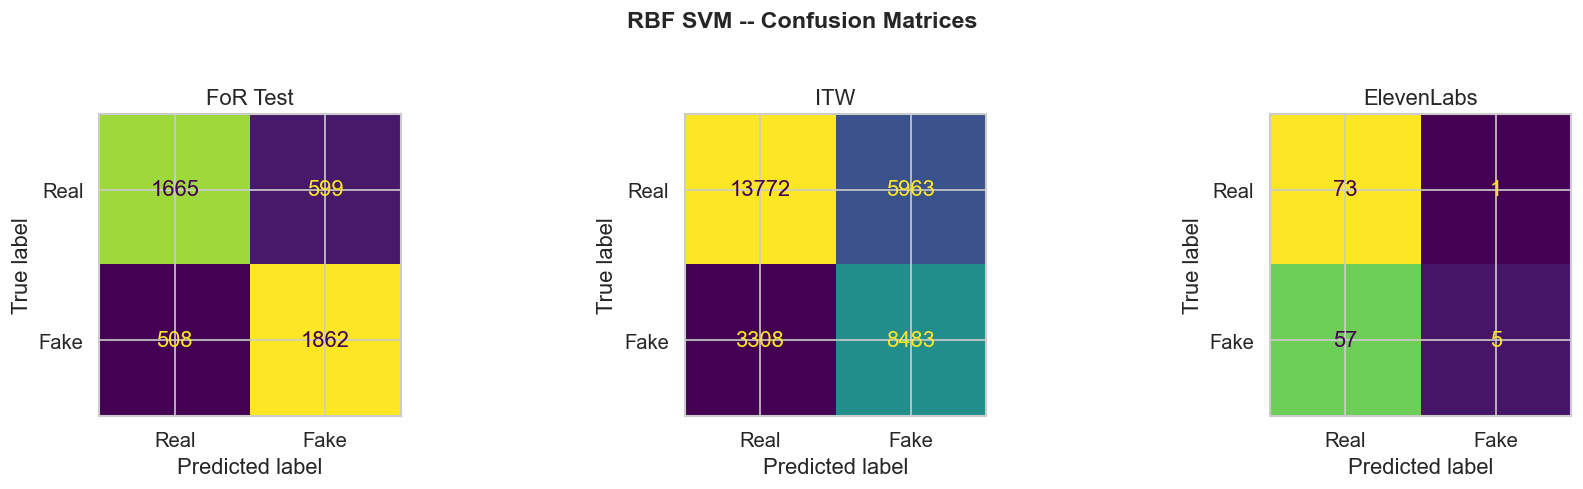

In [ ]:
plot_confusion_matrices(models, datasets, ds_names, suptitle="RBF SVM -- Confusion Matrices")


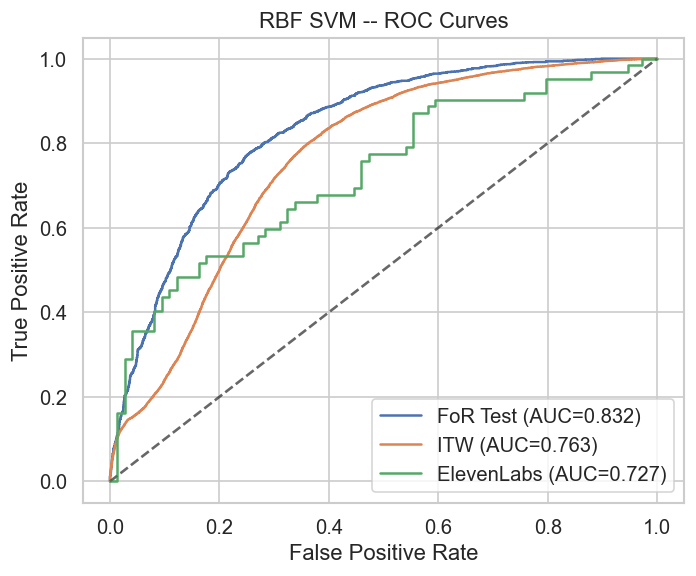

In [ ]:
plot_roc_curves_overlay(models, datasets, ds_names, title="RBF SVM -- ROC Curves")


### 3.4 Polynomial SVM

In [ ]:
name = "Polynomial SVM"

# Load FoR-trained model and final (grid-search best) model
for_dir = os.path.join(FOR_MODELS_PATH, FOR_REGISTRY[name][0])
for_model = joblib.load(os.path.join(for_dir, "model.joblib"))

final_dir = os.path.join(FINAL_MODELS_PATH, MODEL_REGISTRY[name][0])
final_model = joblib.load(os.path.join(final_dir, "model.joblib"))
with open(os.path.join(final_dir, "model_params.json")) as f:
    best_params = json.load(f)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")
print(f"\nBest Parameters: {json.dumps(best_params, indent=2)}")

# Evaluate: FoR model → FoR test,  Final model → ITW & ElevenLabs
m_for, _ = evaluate_model_on_parquet(for_model, FOR_TEST_PATH)
m_itw, _ = evaluate_model_on_parquet(final_model, ITW_PATH)
m_eleven, _ = evaluate_model_on_parquet(final_model, ELEVEN_PATH)

results = {"FoR Test": m_for, "ITW": m_itw, "ElevenLabs": m_eleven}
results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

# For confusion matrices & ROC curves
datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
models = [for_model, final_model, final_model]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

all_results[name] = results


Grid Search Space:
  kernel: ['poly']
  degree: [2, 3]
  C: [0.1, 1, 10]
  gamma: ['scale', 0.01]
  coef0: [0.0, 1.0]

Best Parameters: {
  "svm__C": 1,
  "svm__coef0": 0.0,
  "svm__degree": 2,
  "svm__gamma": 0.01,
  "svm__kernel": "poly"
}


,accuracy,precision,recall,f1_macro,roc_auc
FoR Test,0.7620,0.8000,0.7660,0.7559,0.8474
ITW,0.6742,0.6497,0.6140,0.6144,0.6907
ElevenLabs,0.5441,0.2721,0.5000,0.3524,0.4871


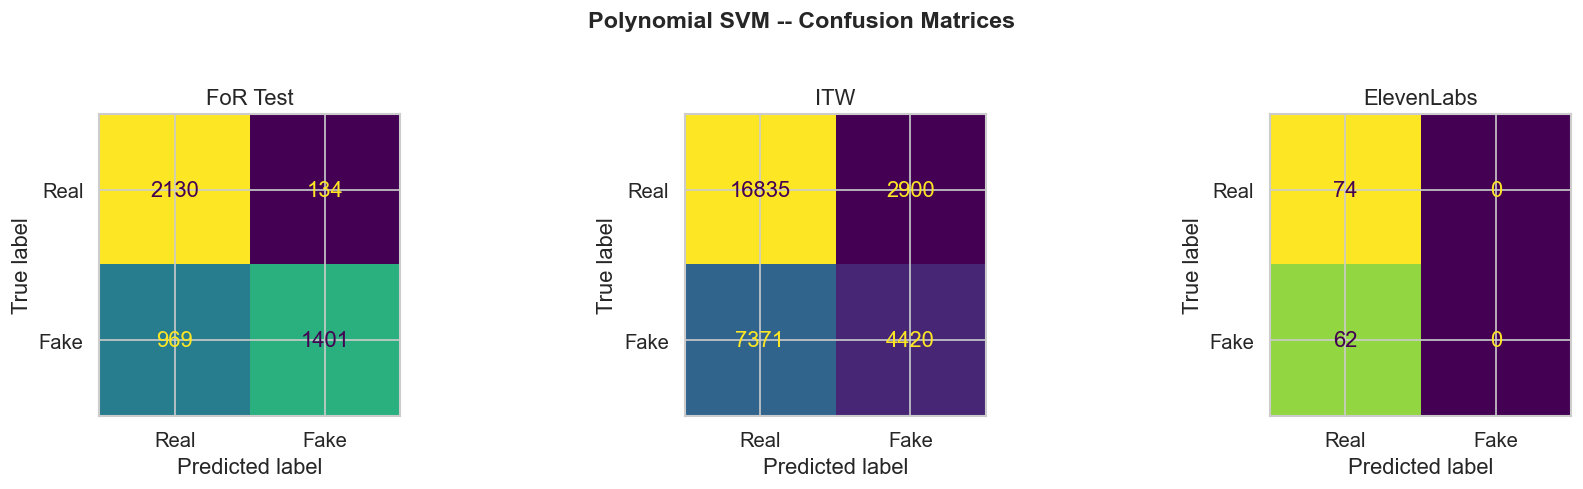

In [ ]:
plot_confusion_matrices(models, datasets, ds_names, suptitle="Polynomial SVM -- Confusion Matrices")


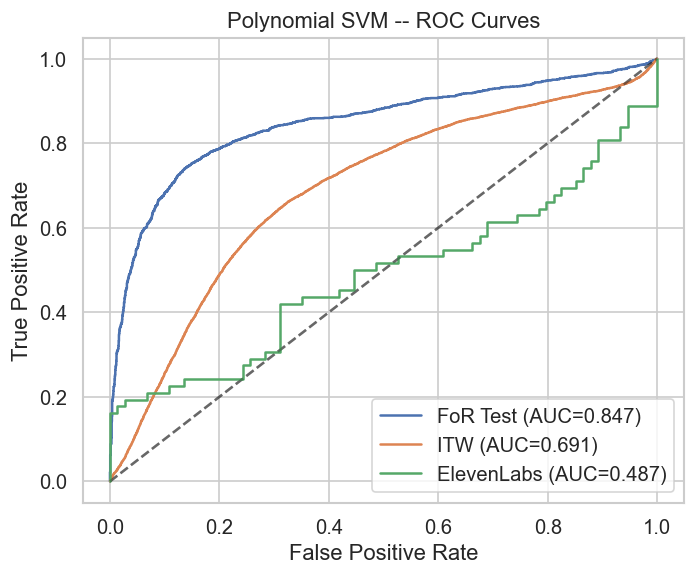

In [ ]:
plot_roc_curves_overlay(models, datasets, ds_names, title="Polynomial SVM -- ROC Curves")


### 3.5 Sigmoid SVM

In [ ]:
name = "Sigmoid SVM"

# Load FoR-trained model and final (grid-search best) model
for_dir = os.path.join(FOR_MODELS_PATH, FOR_REGISTRY[name][0])
for_model = joblib.load(os.path.join(for_dir, "model.joblib"))

final_dir = os.path.join(FINAL_MODELS_PATH, MODEL_REGISTRY[name][0])
final_model = joblib.load(os.path.join(final_dir, "model.joblib"))
with open(os.path.join(final_dir, "model_params.json")) as f:
    best_params = json.load(f)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")
print(f"\nBest Parameters: {json.dumps(best_params, indent=2)}")

# Evaluate: FoR model → FoR test,  Final model → ITW & ElevenLabs
m_for, _ = evaluate_model_on_parquet(for_model, FOR_TEST_PATH)
m_itw, _ = evaluate_model_on_parquet(final_model, ITW_PATH)
m_eleven, _ = evaluate_model_on_parquet(final_model, ELEVEN_PATH)

results = {"FoR Test": m_for, "ITW": m_itw, "ElevenLabs": m_eleven}
results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

# For confusion matrices & ROC curves
datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
models = [for_model, final_model, final_model]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

all_results[name] = results


Grid Search Space:
  kernel: ['sigmoid']
  C: [0.01, 0.1, 1]
  gamma: ['scale', 0.01]
  coef0: [-1.0, 0.0, 1.0]

Best Parameters: {
  "svm__C": 0.1,
  "svm__coef0": -1.0,
  "svm__gamma": "scale",
  "svm__kernel": "sigmoid"
}


,accuracy,precision,recall,f1_macro,roc_auc
FoR Test,0.7268,0.7656,0.7223,0.7137,0.8350
ITW,0.6601,0.6768,0.6864,0.6585,0.7038
ElevenLabs,0.6397,0.6777,0.6140,0.5908,0.6122


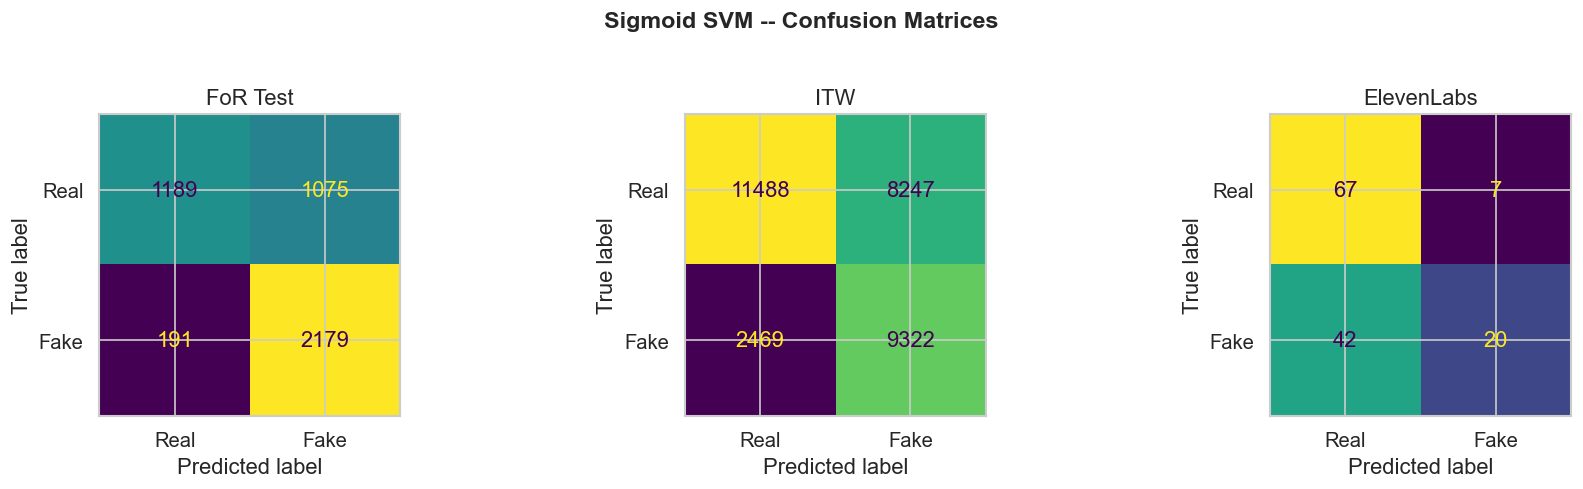

In [ ]:
plot_confusion_matrices(models, datasets, ds_names, suptitle="Sigmoid SVM -- Confusion Matrices")


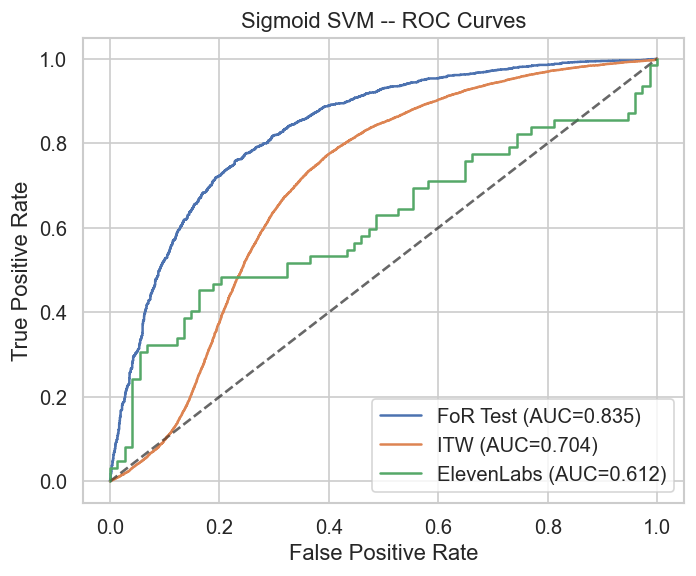

In [ ]:
plot_roc_curves_overlay(models, datasets, ds_names, title="Sigmoid SVM -- ROC Curves")


### 3.6 Decision Tree

In [ ]:
name = "Decision Tree"

for_dir = os.path.join(FOR_MODELS_PATH, FOR_REGISTRY[name][0])
for_model = joblib.load(os.path.join(for_dir, "model.joblib"))

final_dir = os.path.join(FINAL_MODELS_PATH, MODEL_REGISTRY[name][0])
final_model = joblib.load(os.path.join(final_dir, "model.joblib"))

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")

# Extract best params directly from the trained model
dt = final_model.named_steps["dt"] if hasattr(final_model, "named_steps") else final_model
if hasattr(dt, "max_depth"):
    best_params = {
        "max_depth": dt.max_depth,
        "min_samples_split": dt.min_samples_split,
        "min_samples_leaf": dt.min_samples_leaf,
        "criterion": dt.criterion,
        "class_weight": str(dt.class_weight),
        "ccp_alpha": dt.ccp_alpha,
    }
    print(f"\nBest Parameters (from trained model): {json.dumps(best_params, indent=2)}")

# Evaluate: FoR model → FoR test,  Final model → ITW & ElevenLabs
m_for, _ = evaluate_model_on_parquet(for_model, FOR_TEST_PATH)
m_itw, _ = evaluate_model_on_parquet(final_model, ITW_PATH)
m_eleven, _ = evaluate_model_on_parquet(final_model, ELEVEN_PATH)

results = {"FoR Test": m_for, "ITW": m_itw, "ElevenLabs": m_eleven}
results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
models = [for_model, final_model, final_model]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

all_results[name] = results


Grid Search Space:
  max_depth: range(5, 20)
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  class_weight: ['{0:1, 1:5}', None]
  criterion: ['gini', 'entropy']
  ccp_alpha: [0.0, 0.0001, 0.001, 0.01]

Best Parameters (from trained model): {
  "max_depth": 10,
  "min_samples_split": 2,
  "min_samples_leaf": 2,
  "criterion": "gini",
  "class_weight": "{0: 1, 1: 5}",
  "ccp_alpha": 0.0
}


,accuracy,precision,recall,f1_macro,roc_auc
FoR Test,0.9545,0.9565,0.9538,0.9543,0.9588
ITW,0.5905,0.5495,0.5451,0.5446,0.5216
ElevenLabs,0.6691,0.7857,0.6384,0.6044,0.7730


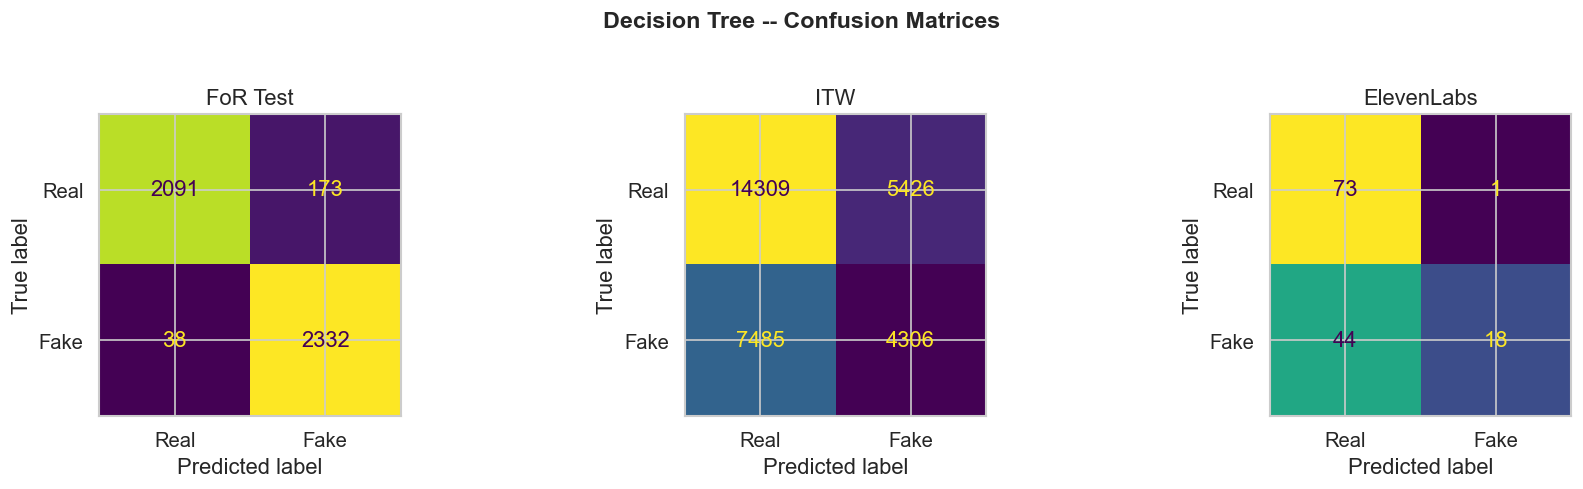

In [ ]:
plot_confusion_matrices(models, datasets, ds_names, suptitle="Decision Tree -- Confusion Matrices")


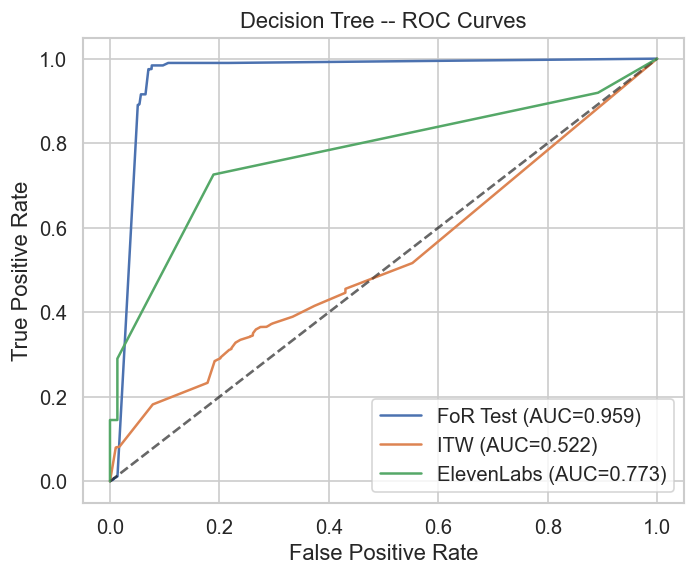

In [ ]:
plot_roc_curves_overlay(models, datasets, ds_names, title="Decision Tree -- ROC Curves")


### 3.7 Random Forest

In [ ]:
name = "Random Forest"

# Load FoR-trained model and final (grid-search best) model
for_dir = os.path.join(FOR_MODELS_PATH, FOR_REGISTRY[name][0])
for_model = joblib.load(os.path.join(for_dir, "model.joblib"))

final_dir = os.path.join(FINAL_MODELS_PATH, MODEL_REGISTRY[name][0])
final_model = joblib.load(os.path.join(final_dir, "model.joblib"))
with open(os.path.join(final_dir, "model_params.json")) as f:
    best_params = json.load(f)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")
print(f"\nBest Parameters: {json.dumps(best_params, indent=2)}")

# Evaluate: FoR model → FoR test,  Final model → ITW & ElevenLabs
m_for, _ = evaluate_model_on_parquet(for_model, FOR_TEST_PATH)
m_itw, _ = evaluate_model_on_parquet(final_model, ITW_PATH)
m_eleven, _ = evaluate_model_on_parquet(final_model, ELEVEN_PATH)

results = {"FoR Test": m_for, "ITW": m_itw, "ElevenLabs": m_eleven}
results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

# For confusion matrices & ROC curves
datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
models = [for_model, final_model, final_model]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

all_results[name] = results


Grid Search Space:
  n_estimators: [300, 500, 700, 800]
  max_depth: [2, 3, 4, 5]
  max_features: ['sqrt', 'log2']
  min_samples_split: [5, 10, 20]
  min_samples_leaf: [2, 5, 10]
  max_samples: [0.5, 0.6, 0.7]
  class_weight: ['{0:1, 1:5}', None]

Best Parameters: {
  "rf__class_weight": null,
  "rf__max_depth": 4,
  "rf__max_features": "sqrt",
  "rf__max_samples": 0.6,
  "rf__min_samples_leaf": 5,
  "rf__min_samples_split": 20,
  "rf__n_estimators": 500
}


,accuracy,precision,recall,f1_macro,roc_auc
FoR Test,0.7659,0.7858,0.7627,0.7602,0.8726
ITW,0.6400,0.6006,0.5655,0.5545,0.6505
ElevenLabs,0.5441,0.2721,0.5000,0.3524,0.8272


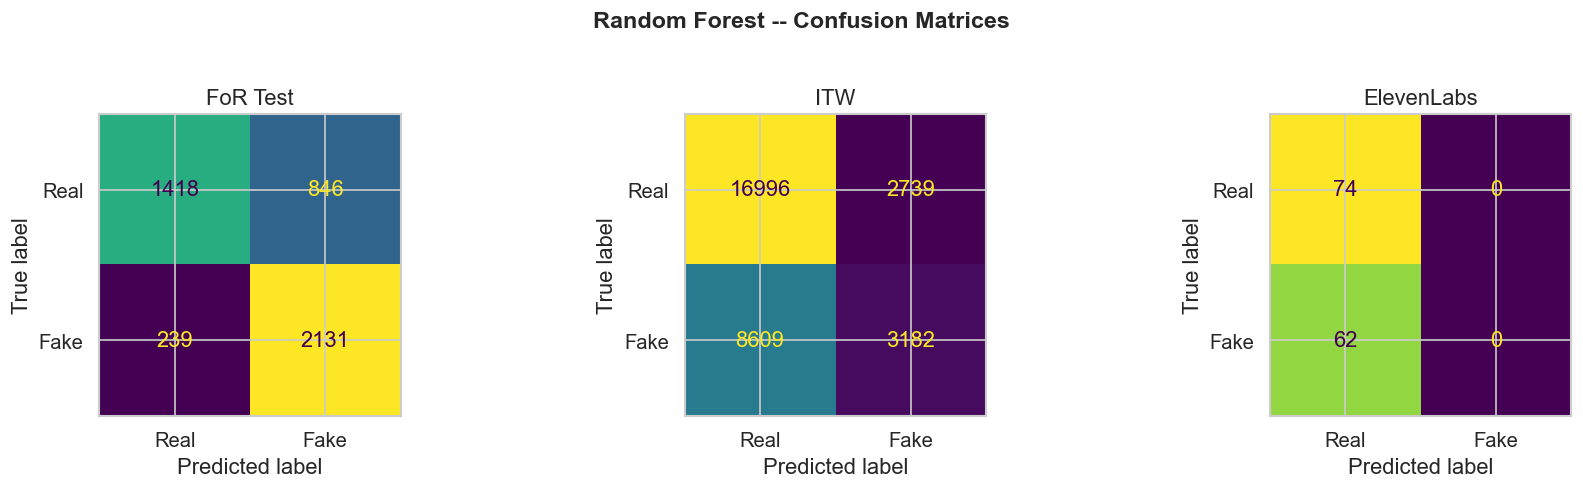

In [ ]:
plot_confusion_matrices(models, datasets, ds_names, suptitle="Random Forest -- Confusion Matrices")


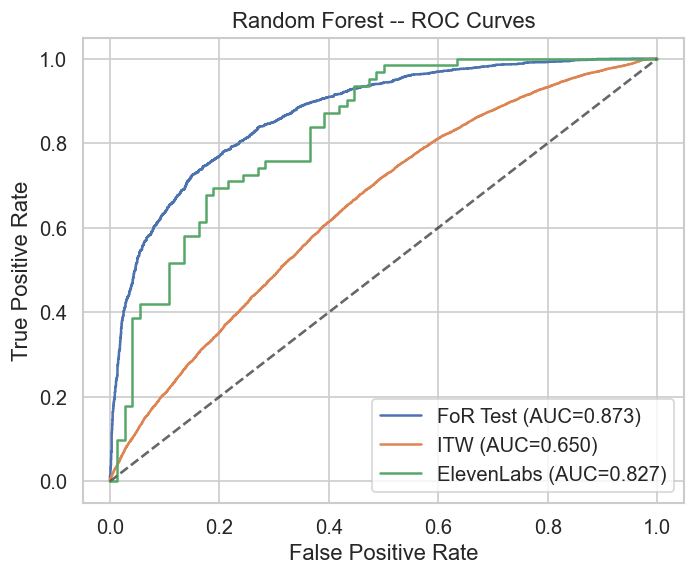

In [ ]:
plot_roc_curves_overlay(models, datasets, ds_names, title="Random Forest -- ROC Curves")


### 3.8 XGBoost

In [ ]:
name = "XGBoost"

# Load FoR-trained model and final (grid-search best) model
for_dir = os.path.join(FOR_MODELS_PATH, FOR_REGISTRY[name][0])
for_model = joblib.load(os.path.join(for_dir, "model.joblib"))

final_dir = os.path.join(FINAL_MODELS_PATH, MODEL_REGISTRY[name][0])
final_model = joblib.load(os.path.join(final_dir, "model.joblib"))
with open(os.path.join(final_dir, "model_params.json")) as f:
    best_params = json.load(f)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")
print(f"\nBest Parameters: {json.dumps(best_params, indent=2)}")

# Evaluate: FoR model → FoR test,  Final model → ITW & ElevenLabs
m_for, _ = evaluate_model_on_parquet(for_model, FOR_TEST_PATH)
m_itw, _ = evaluate_model_on_parquet(final_model, ITW_PATH)
m_eleven, _ = evaluate_model_on_parquet(final_model, ELEVEN_PATH)

results = {"FoR Test": m_for, "ITW": m_itw, "ElevenLabs": m_eleven}
results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

# For confusion matrices & ROC curves
datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
models = [for_model, final_model, final_model]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

all_results[name] = results


Grid Search Space:
  max_depth: [3, 4, 2]
  learning_rate: [0.03, 0.05]
  n_estimators: [700, 800]
  min_child_weight: [10, 20]
  gamma: [0.3]
  reg_lambda: [2, 1]
  reg_alpha: [0.5]
  subsample: [0.6, 0.7, 0.5]
  colsample_bytree: [0.6, 0.7]
  scale_pos_weight: [2]

Best Parameters: {
  "xgb__colsample_bytree": 0.7,
  "xgb__gamma": 0.3,
  "xgb__learning_rate": 0.03,
  "xgb__max_depth": 2,
  "xgb__min_child_weight": 20,
  "xgb__n_estimators": 800,
  "xgb__objective": "binary:logistic",
  "xgb__reg_alpha": 0.5,
  "xgb__reg_lambda": 2,
  "xgb__scale_pos_weight": 2,
  "xgb__subsample": 0.6
}


,accuracy,precision,recall,f1_macro,roc_auc
FoR Test,0.9206,0.9207,0.9209,0.9206,0.9734
ITW,0.6653,0.6959,0.5646,0.5263,0.7282
ElevenLabs,0.5441,0.2721,0.5000,0.3524,0.6643


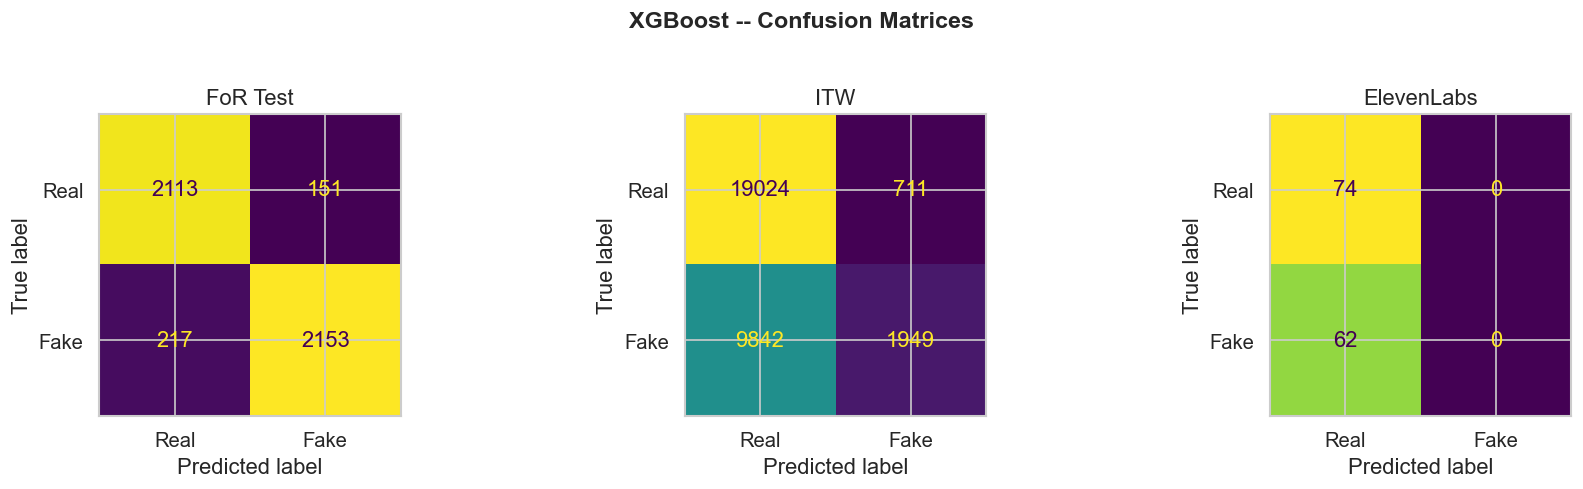

In [ ]:
plot_confusion_matrices(models, datasets, ds_names, suptitle="XGBoost -- Confusion Matrices")


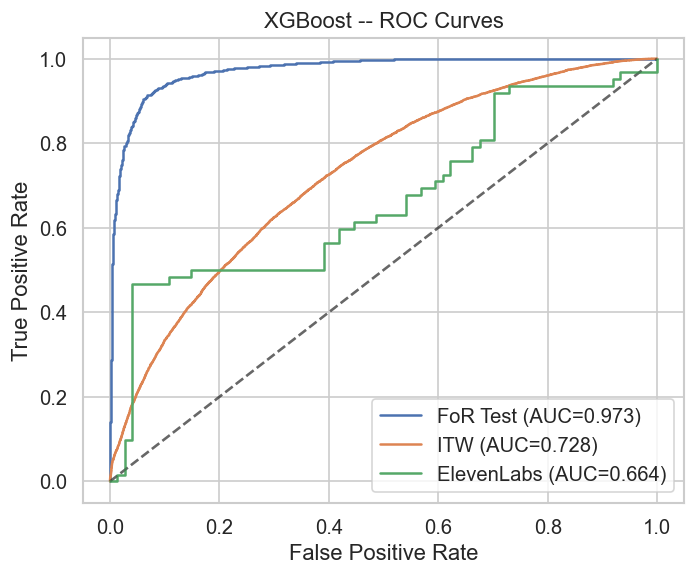

In [ ]:
plot_roc_curves_overlay(models, datasets, ds_names, title="XGBoost -- ROC Curves")


### 3.9 XGBoost (no mel spectrogram features)

In [ ]:
name = "XGBoost (no mel)"

for_dir = os.path.join(FOR_MODELS_PATH, FOR_REGISTRY[name][0])
for_model = joblib.load(os.path.join(for_dir, "model.joblib"))

final_dir = os.path.join(FINAL_MODELS_PATH, MODEL_REGISTRY[name][0])
final_model = joblib.load(os.path.join(final_dir, "model.joblib"))
with open(os.path.join(final_dir, "model_params.json")) as f:
    best_params = json.load(f)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")
print(f"\nBest Parameters: {json.dumps(best_params, indent=2)}")

# Evaluate on no-mel datasets: FoR model → FoR,  Final model → ITW & ElevenLabs
results = {}
if os.path.exists(FOR_TEST_NO_MEL):
    m, _ = evaluate_model_on_parquet(for_model, FOR_TEST_NO_MEL)
    results["FoR Test"] = m
if os.path.exists(ITW_NO_MEL):
    m, _ = evaluate_model_on_parquet(final_model, ITW_NO_MEL)
    results["ITW"] = m
if os.path.exists(ELEVEN_NO_MEL):
    m, _ = evaluate_model_on_parquet(final_model, ELEVEN_NO_MEL)
    results["ElevenLabs"] = m

results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

# For plots
datasets_nm, models_nm, ds_names_nm = [], [], []
if X_for_nm is not None:
    datasets_nm.append((X_for_nm, y_for_nm))
    models_nm.append(for_model)
    ds_names_nm.append("FoR Test")
if X_itw_nm is not None:
    datasets_nm.append((X_itw_nm, y_itw_nm))
    models_nm.append(final_model)
    ds_names_nm.append("ITW")
if X_eleven_nm is not None:
    datasets_nm.append((X_eleven_nm, y_eleven_nm))
    models_nm.append(final_model)
    ds_names_nm.append("ElevenLabs")

all_results[name] = results


Grid Search Space:
  max_depth: [3, 4, 5]
  learning_rate: [0.01, 0.03, 0.05]
  n_estimators: [300, 500, 700]
  min_child_weight: [5, 10, 20]
  gamma: [0.1, 0.3, 0.5]
  reg_lambda: [2, 5, 10]
  reg_alpha: [0, 0.5, 1]
  subsample: [0.6, 0.7, 0.8]
  colsample_bytree: [0.6, 0.7, 0.8]
  scale_pos_weight: [1, 2, 3]

Best Parameters: {
  "xgb__colsample_bytree": 0.6,
  "xgb__gamma": 0.3,
  "xgb__learning_rate": 0.05,
  "xgb__max_depth": 3,
  "xgb__min_child_weight": 20,
  "xgb__n_estimators": 700,
  "xgb__reg_alpha": 0.5,
  "xgb__reg_lambda": 2,
  "xgb__scale_pos_weight": 2,
  "xgb__subsample": 0.6
}


,accuracy,precision,recall,f1_macro,roc_auc
FoR Test,0.7387,0.7442,0.7403,0.7379,0.8239
ITW,0.7415,0.7310,0.6982,0.7059,0.7857
ElevenLabs,0.5441,0.2721,0.5000,0.3524,0.6720


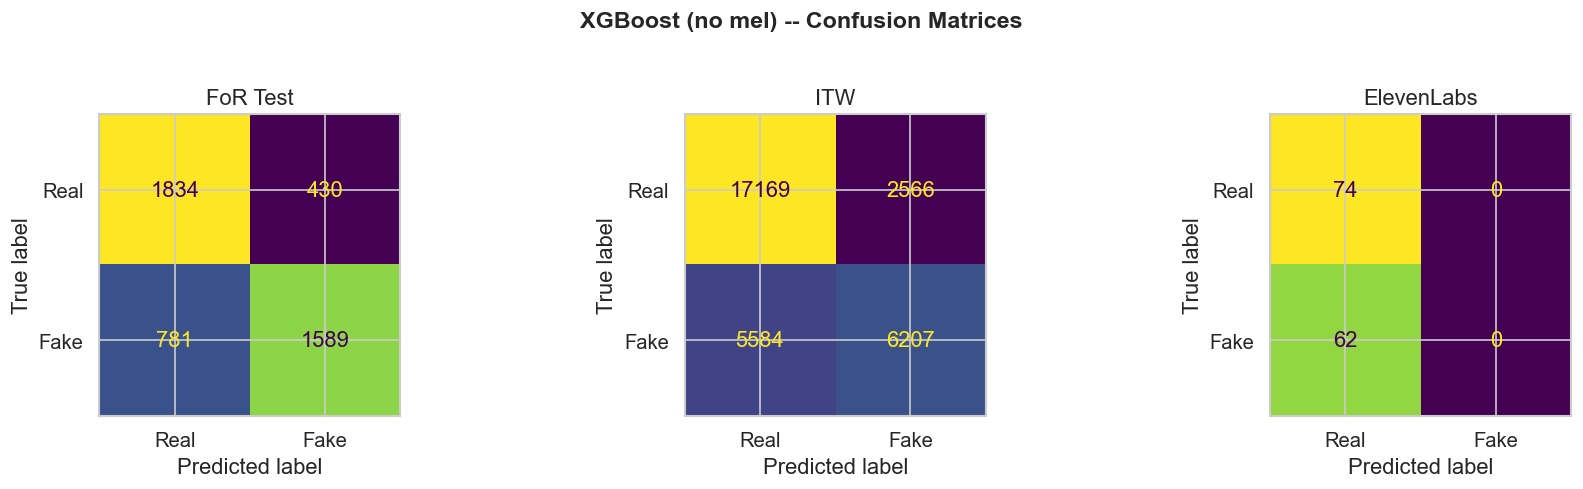

In [ ]:
plot_confusion_matrices(models_nm, datasets_nm, ds_names_nm, suptitle="XGBoost (no mel) -- Confusion Matrices")


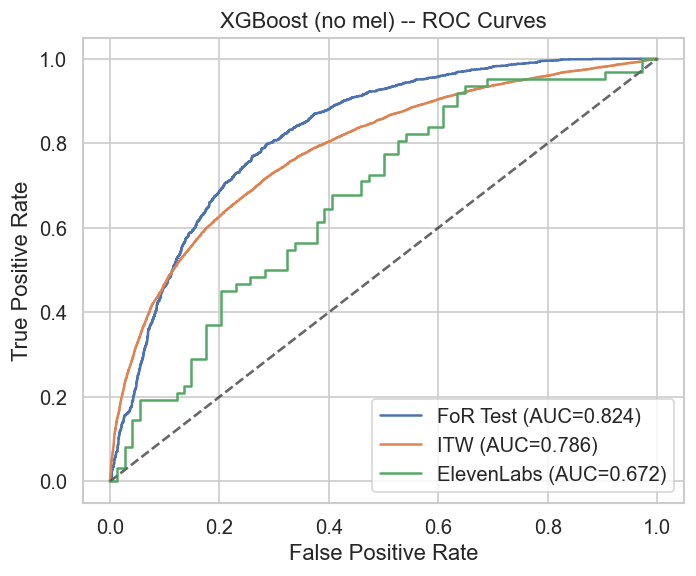

In [ ]:
plot_roc_curves_overlay(models_nm, datasets_nm, ds_names_nm, title="XGBoost (no mel) -- ROC Curves")


---
## 4. Zero-Shot Evaluation Summary

This section compares all models on the In-the-Wild and ElevenLabs datasets, which the models have never seen during training (zero-shot generalization).

In [ ]:
# ── Build comparison tables ──
for_rows = []
itw_rows = []
eleven_rows = []

for model_name, res in all_results.items():
    if "FoR Test" in res:
        for_rows.append({"Model": model_name, **res["FoR Test"]})
    if "ITW" in res:
        itw_rows.append({"Model": model_name, **res["ITW"]})
    if "ElevenLabs" in res:
        eleven_rows.append({"Model": model_name, **res["ElevenLabs"]})

for_df = pd.DataFrame(for_rows).set_index("Model")
itw_df = pd.DataFrame(itw_rows).set_index("Model")
eleven_df = pd.DataFrame(eleven_rows).set_index("Model")

print("=" * 60)
print("FoR Test Set Results")
print("=" * 60)
display(for_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=0))

print()
print("=" * 60)
print("Zero-Shot Results on In-the-Wild Dataset")
print("=" * 60)
display(itw_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=0))

print()
print("=" * 60)
print("Zero-Shot Results on ElevenLabs Dataset")
print("=" * 60)
display(eleven_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=0))


FoR Test Set Results


,accuracy,precision,recall,f1_macro,roc_auc
Model,,,,,
Logistic Regression,0.7279,0.7875,0.7226,0.7099,0.9022
Linear SVM,0.7052,0.7741,0.6993,0.6815,0.8904
RBF SVM,0.7611,0.7614,0.7605,0.7607,0.8323
Polynomial SVM,0.7620,0.8000,0.7660,0.7559,0.8474
Sigmoid SVM,0.7268,0.7656,0.7223,0.7137,0.8350
Decision Tree,0.9545,0.9565,0.9538,0.9543,0.9588
Random Forest,0.7659,0.7858,0.7627,0.7602,0.8726
XGBoost,0.9206,0.9207,0.9209,0.9206,0.9734
XGBoost (no mel),0.7387,0.7442,0.7403,0.7379,0.8239



Zero-Shot Results on In-the-Wild Dataset


,accuracy,precision,recall,f1_macro,roc_auc
Model,,,,,
Logistic Regression,0.7163,0.7060,0.7179,0.7073,0.7775
Linear SVM,0.7200,0.7075,0.7181,0.7097,0.7811
RBF SVM,0.7059,0.6968,0.7086,0.6974,0.7631
Polynomial SVM,0.6742,0.6497,0.6140,0.6144,0.6907
Sigmoid SVM,0.6601,0.6768,0.6864,0.6585,0.7038
Decision Tree,0.5905,0.5495,0.5451,0.5446,0.5216
Random Forest,0.6400,0.6006,0.5655,0.5545,0.6505
XGBoost,0.6653,0.6959,0.5646,0.5263,0.7282
XGBoost (no mel),0.7415,0.7310,0.6982,0.7059,0.7857



Zero-Shot Results on ElevenLabs Dataset


,accuracy,precision,recall,f1_macro,roc_auc
Model,,,,,
Logistic Regression,0.6029,0.7070,0.5671,0.4988,0.6541
Linear SVM,0.6103,0.7158,0.5752,0.5121,0.6707
RBF SVM,0.5735,0.6974,0.5336,0.4314,0.7273
Polynomial SVM,0.5441,0.2721,0.5000,0.3524,0.4871
Sigmoid SVM,0.6397,0.6777,0.6140,0.5908,0.6122
Decision Tree,0.6691,0.7857,0.6384,0.6044,0.7730
Random Forest,0.5441,0.2721,0.5000,0.3524,0.8272
XGBoost,0.5441,0.2721,0.5000,0.3524,0.6643
XGBoost (no mel),0.5441,0.2721,0.5000,0.3524,0.6720


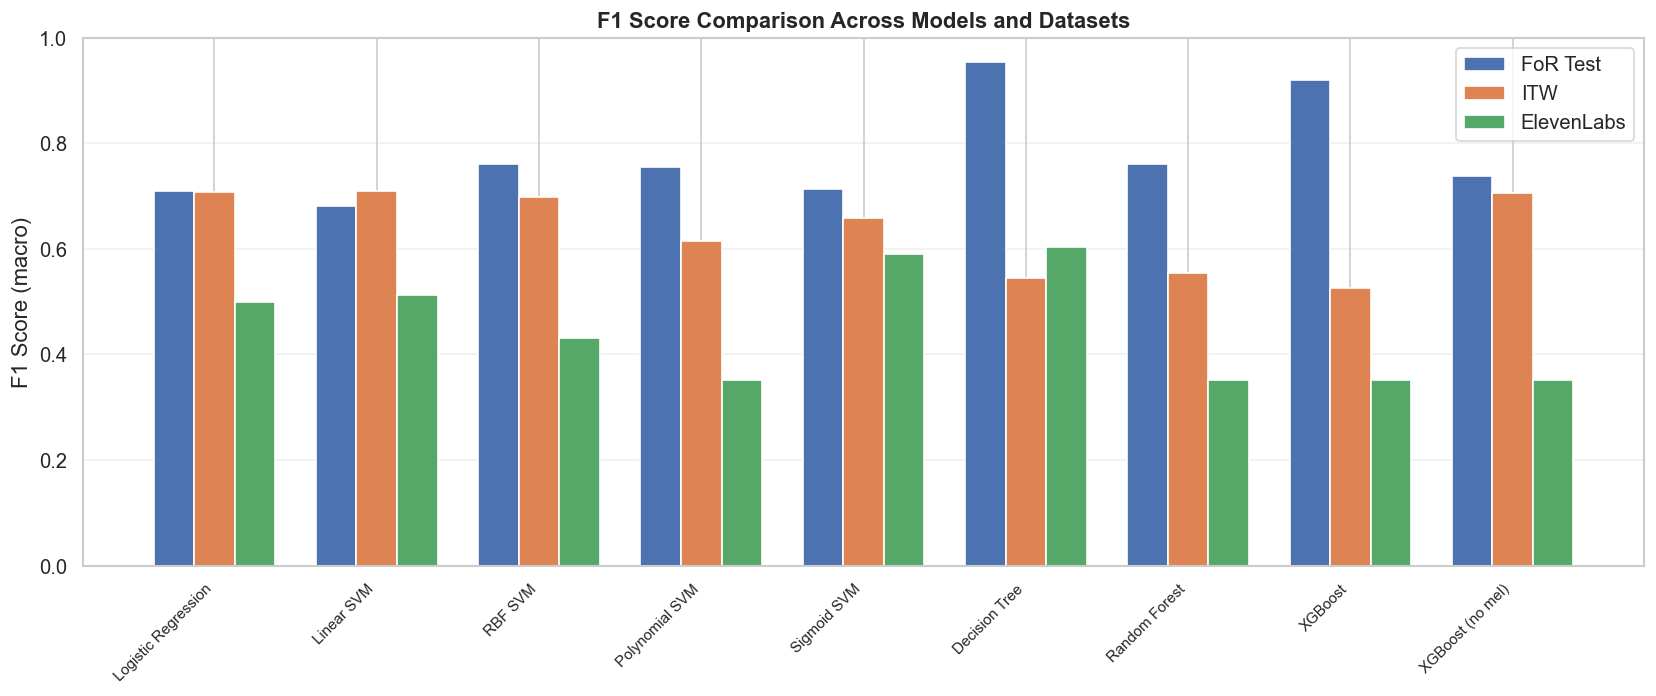

In [ ]:
# ── Grouped bar chart: F1 scores across models and datasets ──
bar_data = []
for model_name, res in all_results.items():
    for ds_name in ["FoR Test", "ITW", "ElevenLabs"]:
        if ds_name in res:
            bar_data.append({
                "Model": model_name,
                "Dataset": ds_name,
                "F1 (macro)": res[ds_name]["f1_macro"]
            })

bar_df = pd.DataFrame(bar_data)

fig, ax = plt.subplots(figsize=(14, 6))
models = list(all_results.keys())
x = np.arange(len(models))
width = 0.25

for i, ds in enumerate(["FoR Test", "ITW", "ElevenLabs"]):
    vals = []
    for m in models:
        if ds in all_results[m]:
            vals.append(all_results[m][ds]["f1_macro"])
        else:
            vals.append(0)
    ax.bar(x + i * width, vals, width, label=ds)

ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=45, ha="right", fontsize=9)
ax.set_ylabel("F1 Score (macro)")
ax.set_title("F1 Score Comparison Across Models and Datasets", fontweight="bold")
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

---
## 5. Conclusion

### Evaluation Methodology

Each classifier was evaluated using two model instances:

- **FoR Models:** Trained on the FoR Training Set, validated on the FoR Validation Set, and tested on the Test Set.
- **Final Models:** Trained on the FoR Training Set, validated on the FoR Test Set, and evaluated on the entire ITW Dataset. These models were developed to address data leakage identified in the original FoR Validation Set. By shifting validation to the FoR Test Set, we were able to perform grid search optimization, resulting in significantly better generalization on unseen data.

For all models, we applied class weighting to prioritize the **fake** class, reflecting the critical importance of its detection.

### FoR Test Set Performance

- **Decision Tree** achieves the highest FoR test accuracy (95.45%, F1=0.954, AUC=0.959), followed by **XGBoost** (92.06%, F1=0.921, AUC=0.973). These models exceled when they were trained and attempted to predict data in this specific dataset. Although, such high scores in these methods indicate that the model has overfitted to the training data.
- **Polynomial SVM** (76.20%) and **RBF SVM** (76.11%) form a mid-tier, while **Logistic Regression** (72.79%) and **Linear SVM** (70.52%) are lower in accuracy but achieve notably high AUC (0.90 and 0.89 respectively), indicating strong probability ranking.

### Zero-Shot Generalization

As an experiment we curated a mini-dataset using the Eleven-Labs **Eleven Multilingual V2** model. We recorded audios of ourselves paying attention to have the same audio characteristics (sample rate, audio channels etc.) and created small ~ 5s utterances of TTS audio. The implementation can be found [`here`](../scripts/eleven.py),

- All models experience a significant performance drop on ITW and ElevenLabs, confirming the expected domain shift between controlled FoR recordings and real-world deepfakes, especially when generated from a state-of-the-art model.
- **XGBoost (no mel)** is the strongest generalizer among the final models (74.15% accuracy, AUC=0.786 on ITW), followed by **Linear SVM** (72.00%) and **Logistic Regression** (71.63%). A point should be made regarding **XGBoost which required extensive grid search (~59k iterations over 6.5 hours) in order to achieve this score.
- **Decision Tree** suffers the most severe generalization collapse (59.05% accuracy, AUC=0.522 on ITW), despite being the best on FoR. This confirms heavy overfitting to FoR-specific audio characteristics.
- **ElevenLabs** poses the hardest challenge, with all models showing substantially lower scores than on ITW. This is likely because ElevenLabs deepfakes are generated with higher-quality synthesis that produces acoustic features closer to real speech. A noteable performer for this Dataset, contradicting its ITW score, is the Decision Tree produced model, achieving the most detected true fakes.

### Specificity vs. Generality Trade-Off

There is a clear inverse relationship between same-distribution (FoR Test - Train) performance and cross-domain generalization:
- Models that achieve the highest FoR accuracy (Decision Tree, XGBoost) are the weakest generalizers.
- Models with more modest FoR accuracy (Logistic Regression, Linear SVM, XGBoost no-mel) generalize more consistently, likely because their simpler decision boundaries are less susceptible to dataset-specific artifacts.

### Impact of Mel Spectrogram Features

- Comparing **XGBoost** (195 features, with mel) vs. **XGBoost no-mel** (67 features, without mel): removing mel spectrogram features dramatically improved generalization (ITW accuracy: 66.53% to 74.15%; ITW F1: 0.526 to 0.706).
- The correlation heatmaps reveal strong redundancy within mel spectrogram bands, which likely causes tree-based models to overfit to dataset-specific spectral patterns rather than learning generalizable deepfake signatures.
- MFCC, delta, and spectral features provide more robust representations for cross-domain detection.

### Feature Selection Insights

- Empirical feature selection using logistic regression prediction scores showed that keeping only mean aggregations (dropping standard deviation features) improved FoR validation F1 from 0.72 to 0.78.
- Mel spectrogram features remain essential for same-distribution performance -- removing them causes FoR validation F1 to drop to 0.55 -- but they hurt generalization for tree-based models.
